In [1]:
# File Authorship Information
__author__ = """Matteo Lulli, Emily S. C. Ching"""
__copyright__ = """Matteo Lulli, Emily S. C. Ching, idea.deploy"""
__license__ = """Permission is hereby granted, free of charge, 
to any person obtaining a copy of this software and associated 
documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to 
use, copy, modify, merge, publish, distribute, sublicense, 
and/or sell copies of the Software, 
and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:
The above copyright notice and this permission notice shall be 
included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, 
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES 
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE."""
__maintainer__ = "Matteo Lulli"
__email__ = "matteo.lulli@gmail.com"
__status__ = "Development"

In [2]:
# Fix for using VSCode with a single Jupyter server session started at the root directory of 'idea.deploy'
if True:
    import os
    notebook_path = os.path.abspath(".") + '/papers/arXiv-2505.23647/'
    os.chdir(os.path.dirname(notebook_path))

# Development cell
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

# Higher-order Tuning of Interface Physics in Multiphase Lattice Boltzmann

Authors: Matteo Lulli, Emily S. C. Ching


**Abstract:**
Tuning the interface properties of multiphase models is of paramount importance to the final goal of achieving a one-to-one matching with nucleation and cavitation experiments. The surface tension, at the leading order, and the Tolman length, at higher order, play a crucial role in the estimation of the free-energy barrier determining the experimentally observed nucleation rates. The lattice Boltzmann method allows for a computationally efficient modelling approach of multiphase flows, however, tuning results are concerned with the surface tension and neglect the Tolman length. We present a novel perspective that leverages all the degrees of freedom hidden in the forcing stencil of the Shan-Chen multiphase model. By means of the lattice pressure tensor we determine and tune the coefficients of higher-order derivative terms related to surface tension and Tolman length at constant interface width and density ratio. We test the method by means of both hydrostatic and dynamic simulations and demonstrate the dependence of homogeneous nucleation rates on the value of the Tolman length. This work provides a new tool that can be integrated with previously existing strategies thus marking a step forwards to a high-fidelity modelling of phase-changing fluid dynamics.

# Reproducibility

This document is intended for those interested readers who want to reproduce the results reported in the paper [](). In the present case the computational resources needed should be available in general. 

Next development steps will include a class to measure the time required by each cell and output it in a .json file which can be sent to [matteo.lulli@gmail.com](mailto:matteo.lulli@gmail.com) so that average execution times will be available and organized according to the hardware.

Each subsection can be executed independently and reproduce the results which will be stored locally in the directory 'reproduced-data', so that the data will be generated only once.

Plots can also be generated using the same scripts employed for the figures of the paper. Since there are some issues in executing these scripts in the Jupyter environment we include them as separated files which are called from the cells themselves. **In order to reproduce the plots a working 'latex' installation is necessary to be present on the system.**

This file will be kept updated for new local features and developments in the parent project [**idea.deploy**](https://github.com/lullimat/idea.deploy)

This file is supposed to be pulled from the repository [](), from within the "papers" directory the idea.deploy project.

## Table I

In [3]:
## Computing the weights of the stencils according to
## M. Sbragaglia, R. Benzi, L. Biferale, S. Succi, K. Sugiyama, and F. Toschi, Physical Review E 75
## https://doi.org/10.1103/physreve.75.026702

from idpy.LBM.SCFStencils import SCFStencils, BasisVectors
from idpy.IdpyStencils.IdpyStencils import IDStencils

D2E4_orig, D3E4_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2]), IDStencils['LBM']['SC_D3E4']
print(D2E4_orig.FindWeights())

D2E6_orig, D3E6_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4]), IDStencils['LBM']['SC_D3E6']
print(D2E6_orig.FindWeights())

D2E8_orig, D3E8_orig = \
    SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4,5,8]), IDStencils['LBM']['SC_D3E8']
print(D2E8_orig.FindWeights())

D2E10_orig, D3E10_orig = \
    SCFStencils(E = BasisVectors(x_max = 3), len_2s = [1,2,4,5,8,9,10]), IDStencils['LBM']['SC_D3E10']
print(D2E10_orig.FindWeights())

D2E12_orig = \
    SCFStencils(E = BasisVectors(x_max = 4), len_2s = [1,2,4,5,8,9,10,13,16,17])
print(D2E12_orig.FindWeights())

## Computing the isotropy coefficients - 2d and 3d coincide because the 3d stencils exactly projects onto the 2d ones

stencil_objs = [D2E4_orig, D2E6_orig, D2E8_orig, D2E10_orig, D2E12_orig]
stencil_vecs = [D2E4_orig.PushStencil(), D2E6_orig.PushStencil(), D2E8_orig.PushStencil(), D2E10_orig.PushStencil(), D2E12_orig.PushStencil()]

slabs = {D2E4_orig: r'E^{(4)}', D2E6_orig: r'E^{(6)}', D2E8_orig: r'E^{(8)}', D2E10_orig: r'E^{(10)}', D2E12_orig: r'E^{(12)}'}
es_vals_dict = {}
for label, twod_stencil in zip(stencil_objs, stencil_vecs):
    es_vals_dict[label] = {}
    
    Ws, XIs = np.array(twod_stencil['Ws']), np.array(twod_stencil['Es'])
    ## 4th
    n0, n1 = 2, 2
    es_vals_dict[label][4] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)))
    ## 6th
    n0, n1 = 4, 2
    es_vals_dict[label][6] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1))  / sp.factorial2(3))
    ## 8th
    n0, n1 = 4, 4
    es_vals_dict[label][8] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(3) ** 2))
    ## 10th
    n0, n1 = 6, 4
    es_vals_dict[label][10] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(5) * sp.factorial2(3)))
    ## 12th
    n0, n1 = 6, 6
    es_vals_dict[label][12] = str(np.sum(Ws * (XIs[:, 0] ** n0) * (XIs[:, 1] ** n1)) / (sp.factorial2(5) ** 2))

## Computing the number of vectors in each stencil

vecs_n_2d = {s: str(len(s.PushStencil()['Es'])) for s in stencil_objs}

from idpy.Utils.Geometry import GetDihedralVectorsG

### Using the 2d labels also for the 3d case
vecs_n_3d = {}
vecs_4_3d = [(1, 0, 0), (1, 1, 0)]
vecs_n_3d[D2E4_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_4_3d]))

vecs_6_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0)]
vecs_n_3d[D2E6_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_6_3d]))

vecs_8_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0)]
vecs_n_3d[D2E8_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_8_3d]))

vecs_10_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (3, 0, 0), (3, 1, 0), (3, 1, 1)]
vecs_n_3d[D2E10_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_10_3d]))

vecs_12_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (3, 0, 0), (3, 1, 0), (3, 1, 1), 
              (3, 2, 0), (3, 2, 1), (4, 0, 0), (3, 2, 2), (3, 3, 0)]
vecs_n_3d[D2E12_orig] = str(np.sum([len(GetDihedralVectorsG(np.array(v))) for v in vecs_12_3d]))

## Generating the table

from IPython.display import display, Latex

table_I = r"""
\begin{array}{lccccc}
& """ + slabs[D2E4_orig] + r"""& """ + slabs[D2E6_orig] + r"""& """ + slabs[D2E8_orig] + r"""& """ + slabs[D2E10_orig] + r"""& """ + slabs[D2E12_orig] + r"""\\
\hline
e_4 & """ + es_vals_dict[D2E4_orig][4] + r""" & """ + es_vals_dict[D2E6_orig][4] + r""" & """ + es_vals_dict[D2E8_orig][4] + r""" & """ + es_vals_dict[D2E10_orig][4] + r""" & """ + es_vals_dict[D2E12_orig][4] + r""" \\
e_6 & """ + es_vals_dict[D2E4_orig][6] + r""" & """ + es_vals_dict[D2E6_orig][6] + r""" & """ + es_vals_dict[D2E8_orig][6] + r""" & """ + es_vals_dict[D2E10_orig][6] + r""" & """ + es_vals_dict[D2E12_orig][6] + r""" \\
e_8 & """ + es_vals_dict[D2E4_orig][8] + r""" & """ + es_vals_dict[D2E6_orig][8] + r""" & """ + es_vals_dict[D2E8_orig][8] + r""" & """ + es_vals_dict[D2E10_orig][8] + r""" & """ + es_vals_dict[D2E12_orig][8] + r""" \\
e_{10} & """ + es_vals_dict[D2E4_orig][10] + r""" & """ + es_vals_dict[D2E6_orig][10] + r""" & """ + es_vals_dict[D2E8_orig][10] + r""" & """ + es_vals_dict[D2E10_orig][10] + r""" & """ + es_vals_dict[D2E12_orig][10] + r""" \\
e_{12} & """ + es_vals_dict[D2E4_orig][12] + r""" & """ + es_vals_dict[D2E6_orig][12] + r""" & """ + es_vals_dict[D2E8_orig][12] + r""" & """ + es_vals_dict[D2E10_orig][12] + r""" & """ + es_vals_dict[D2E12_orig][12] + r""" \\
% \hline
N_e,\;d=2 & """ + vecs_n_2d[D2E4_orig] + r""" & """ + vecs_n_2d[D2E6_orig] + r""" & """ + vecs_n_2d[D2E8_orig] + r""" & """ + vecs_n_2d[D2E10_orig] + r""" & """ + vecs_n_2d[D2E12_orig] + r""" \\
N_e,\;d=3 & """ + vecs_n_3d[D2E4_orig] + r""" & """ + vecs_n_3d[D2E6_orig] + r""" & """ + vecs_n_3d[D2E8_orig] + r""" & """ + vecs_n_3d[D2E10_orig] + r""" & """ + vecs_n_3d[D2E12_orig] + r""" \\
\end{array}
"""

display(Latex(table_I))
print(table_I)

[1/3, 1/12]
[4/15, 1/10, 1/120]
[4/21, 4/45, 1/60, 2/315, 1/5040]
[262/1785, 93/1190, 7/340, 6/595, 9/9520, 2/5355, 1/7140]
[68/585, 68/1001, 1/45, 62/5005, 1/520, 4/4095, 2/4095, 2/45045, 1/480480, 0]


<IPython.core.display.Latex object>


\begin{array}{lccccc}
& E^{(4)}& E^{(6)}& E^{(8)}& E^{(10)}& E^{(12)}\\
\hline
e_4 & 1/3 & 2/5 & 4/7 & 12/17 & 120/143 \\
e_6 & 1/9 & 2/15 & 32/105 & 8/17 & 96/143 \\
e_8 & 1/27 & 2/45 & 16/105 & 176/595 & 512/1001 \\
e_{10} & 1/135 & 2/225 & 16/225 & 104/595 & 1856/5005 \\
e_{12} & 1/675 & 2/1125 & 16/525 & 288/2975 & 256/1001 \\
% \hline
N_e,\;d=2 & 8 & 12 & 24 & 36 & 56 \\
N_e,\;d=3 & 18 & 32 & 92 & 170 & 284 \\
\end{array}



## Results V.A: Leading order surface tension tuning - $\hat{\sigma}_0$

In [4]:
# Relevant Thermodynamics Functions

from scipy.interpolate import UnivariateSpline

def SpinodalPsi(G, psi_sym, n_sym, n_min = 1e-4, n_max = 10):
    dpsi_sym = sp.diff(psi_sym, (n_sym, 1))
    psi_f = sp.lambdify([n_sym], psi_sym)
    dpsi_f = sp.lambdify([n_sym], dpsi_sym)
    n_range = np.linspace(n_min, n_max, 2 ** 13)
    dpsi_0_spl = UnivariateSpline(n_range, 1 / 3 + G * psi_f(n_range) * dpsi_f(n_range), s=0)
    n_spin = dpsi_0_spl.roots()
    # return n_spin, n_range, dpsi_0_spl
    return n_spin


def FindDensityFromPressure(G, psi_sym, n_sym, p_target, n_s_values, branch='n_g', exp_2 = 8, n_max = 10):
    n_s_vals = n_s_values
    psi_f = sp.lambdify([n_sym], psi_sym)

    if branch == 'n_g':
        n_s = n_s_vals[0]
        n_range = np.linspace(1e-4, n_s, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

    if branch == 'n_l':
        n_s = n_s_vals[1]
        n_range = np.linspace(n_s, n_max, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

def FindBulkDensitiesDropletLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

def FindBulkDensitiesBubbleLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

from scipy.optimize import newton

def MaxwellEqualAreaIntegral(p0_val, G_val, psi_sym, n_sym, ns_g, ns_l, pb_lam, exp_2 = 10):
    ng_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_g', exp_2 = 10, n_max=4)
    nl_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_l', exp_2 = 10, n_max=4)
    n_fine_adapted = np.linspace(ng_p0, nl_p0, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MyNewton(p_min, p_max, MEAInteg_lam, accuracy = 1e-10):
    print(p_min, p_max, MEAInteg_lam(p_min), MEAInteg_lam(p_max))
    steps_count = 0
    MI_min, MI_max = MEAInteg_lam(p_min), MEAInteg_lam(p_max)
    while np.abs(MEAInteg_lam((p_min + p_max) * 0.5)) > accuracy:
        new_p = (p_min + p_max) * 0.5
        new_MI = MEAInteg_lam(new_p)
        steps_count += 1
        if new_MI * MI_min > 0:
            MI_min, p_min = new_MI, new_p
        else:
            MI_max, p_max = new_MI, new_p
    return (p_min + p_max) * 0.5, steps_count

"""
Psi profile: always assuming Eq. 
"""
def MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2 = 10):
    n_fine_adapted = np.linspace(ng_val, n_val, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MaxwellProfilePsiD2(n_val, ng_val, p0_val, eps_val, G_val, pb_lam, exp_2 = 10):
    return ((8 * (1 - float(eps_val)) / G_val.evalf()) * (n_val / (float(eps_val) + n_val)) * \
            MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2))


def GetPsiProfile(delta_n, psi_sym, n_sym, eq_params, kickstart = 1e-1):
    psi_f = sp.lambdify([n_sym], psi_sym)
    psi_prime = sp.diff(psi_sym, (n_sym, 1))
    psi_prime_f = sp.lambdify([n_sym], psi_prime)
    n_range_width = eq_params['n_l'] * (1 - kickstart) - eq_params['n_g'] * (1 + kickstart)
    print(int(n_range_width / delta_n))
    n_range = np.linspace(eq_params['n_l'] * (1 - kickstart), eq_params['n_g'] * (1 + kickstart), int(n_range_width / delta_n))
    dn = np.abs(n_range[1] - n_range[0])
    dx_s = []
    for n_val in n_range:
        # print(np.sqrt(np.float64(dpsi2_lam(n_val))))
        dx_s += [dn * psi_prime_f(n_val) / np.sqrt(np.float64(dpsi2_lam(n_val)))]
    dx_s = np.array(dx_s)
    x_range = np.array([np.sum(dx_s[:i]) for i in range(len(dx_s))])
    return x_range, psi_f(n_range), n_range


### Simulations

In [5]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

CUDA Found!

CUDA GPU[0]
Name :  NVIDIA A100-SXM4-80GB
Memory :  84974239744
DrvVersion :  (12, 4, 0)


OpenCL Found!

Listing GPUs:

Listing CPUs:
OpenCL CPU[0]
Name :  pthread-Intel(R) Xeon(R) Platinum 8468
Memory :  2161827287040
Double :  191
DrvVersion :  1.8


CTypes Found!

Listing CPUs:
Device: CPU Intel(R) Xeon(R) Platinum 8468 Memory:2163974770688




In [6]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

from InterfaceTuning import InterfaceTuningSims

from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

In [7]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}


- By executing the cell below one can avoid performing the calculation of the equilibrium interface properties from scratch

In [ ]:
! cp ./non-reproduced-results/eq-prop-Sigma0.json ./reproduced-results/eq-prop-Sigma0.json

In [8]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D
from idpy.Utils.ManageData import ManageData

def GetFileNameSigma0(G_eps, e4_val, dim_sizes):
    name_str = "Sigma0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(float(e4_val)) + '_' + str(dim_sizes)
    return name_str + '.hdf5'

def GetFileNameSigma0STD(G_eps, e4_val, dim_sizes):
    name_str = "Sigma0TuningSTD_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(float(e4_val)) + '_' + str(dim_sizes)
    return name_str + '.hdf5'

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

""" 
Computing standard 2d stencils
"""

from idpy.LBM.SCFStencils import SCFStencils, BasisVectors

D2E4_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2])
D2E6_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4])
D2E8_std = SCFStencils(E = BasisVectors(x_max = 2), len_2s = [1,2,4,5,8])
D2E10_std = SCFStencils(E = BasisVectors(x_max = 3), len_2s = [1,2,4,5,8,9,10])
D2E12_std = SCFStencils(E = BasisVectors(x_max = 4), len_2s = [1,2,4,5,8,9,10,13,16,17])

D2E4_std.FindWeights()
D2E6_std.FindWeights()
D2E8_std.FindWeights()
D2E10_std.FindWeights()
D2E12_std.FindWeights()

std_stencils_2d = [D2E4_std, D2E6_std, D2E8_std, D2E10_std, D2E12_std]
std_2d_names = {D2E4_std: 'D2E4', D2E6_std: 'D2E6', D2E8_std: 'D2E8', D2E10_std: 'D2E10', D2E12_std: 'D2E12'}

"""
Computing custom stencils
"""
print("Computing custom stencil: 3d")
it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 2, 0)],
                                        l2_list_2d = [1, 2, 4, 5, 8])

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)]])



sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

"""
Defining the custom reference stencil: 2d
"""
print("Computing custom stencil: 2d")
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 8])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 4 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0]])

eq_prop_dump = root_dir_res / 'eq-prop-Sigma0.json'
psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

## Need to move this down

G_eps = 0.4

print("Computing/retreiving equilibrium interface properties...")
if not eq_prop_dump.is_file():
    n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
    print("Pseudopotential:")
    display(psi_sym)
    print()
    print("Critical coupling:", G_c, "Critical density:", n_c)

    G_val = G_c * (G_eps + 1)

    """ 
    Computing thermodynamic properties
    """
    ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
    pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

    MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

    p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
    ng_eq, nl_eq = \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

    print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
    print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

    eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


    """
    Using a common value for the flat surface tension for initializing the densities
    """
    dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

    dpsi_sym = sp.diff(psi_sym, (n, 1))
    dpsi_lam = sp.lambdify([n], dpsi_sym)
    psi_lam = sp.lambdify([n], psi_sym)

    d2psi_lam = \
        lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                    (8 * ((1 - float(0)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

    n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
    print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
    dn_int = np.abs(n_range[1] - n_range[0])

    Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
    # eq_params['Sigma_11'] = Sigma_11
    # Sigma1_th = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

    """
    This value of the surface tension is computed assuming e_4 = 2 / 5 as reported in Table I,
    corresponding to the standard 6th order isotropic stencil
    """
    sigma_flat_value = np.float64(G_val * ((-(2 / 5) / 2) * Sigma_11))
    eq_params['sigma_f'] = sigma_flat_value

    print()
    print("sigma_f:", eq_params['sigma_f'])
    print()

    from idpy.Utils.DictHandle import RunThroughDict, Edit_AllFloat
    RunThroughDict(eq_params, edit_function=Edit_AllFloat)

    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(eq_prop_dump))
    md.PushData(data=eq_params, key='eq_params')
    md.DumpJson(indent=4)
else:
    md = ManageData(dump_file=str(eq_prop_dump))
    md.ReadJson()
    eq_params = md.PullData(key='eq_params')

    G_val = eq_params['G_c'] * (G_eps + 1)
    
dump_file_sims = root_dir_res / 'Figure2-data-points.json'

if not dump_file_sims.is_file():
    print("File", str(dump_file_sims), "not found. Running the simulations...")
    """
    Standard stencils simulations
    """
    maxu_2d_std = {}
    if True:
        for std_stencil in std_stencils_2d:
            G = float(G_val)

            Ws_swap, Es_swap = np.array(std_stencil.PushStencil()['Ws']), np.array(std_stencil.PushStencil()['Es'])
            e4_val = np.sum(Ws_swap * (Es_swap[:, 0] ** 2) * (Es_swap[:, 1] ** 2))

            dim_sizes = (127, 127)   
            dump_file_name = root_dir_res / Path(GetFileNameSigma0STD(np.float64(G_eps), e4_val, dim_sizes))
            print(dump_file_name, dump_file_name.is_file())

            # if dump_file_name.is_file():
            #     dump_file_name.unlink()

            droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                eq_params=eq_params,
                                                                n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                sigma_pref = 1)

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                n_field = IT_sim.Run2D(
                    f_stencil=std_stencil.PushStencil(),
                    n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                    dump_name=dump_file_name, kind='droplet', delta_strip=4, get_n_field=True)
                
            print(ReadLaplaceData(dump_file_name))
            maxu_2d_std[std_2d_names[std_stencil]] = ReadLaplaceData(dump_file_name)['max_u']



    """
    Custom stencils simulations
    """
    e4_values = np.sort(np.array([sp.Rational(k, 10) for k in range(4, 18 + 1)] + [sp.Rational(1, 3), sp.Rational(4, 7)]))
    print(e4_values)

    maxu_2d, maxu_3d, n_fields_2d = [], [], []
    if True:
        for e4_val in e4_values:

            tuned_stencil = it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val})
            tuned_stencil_2d = it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val})

            display(np.sum(np.array(tuned_stencil['Ws']) * (np.array(tuned_stencil['XIs'])[:, 0] ** 2) * (np.array(tuned_stencil['XIs'])[:, 1] ** 2)))

            flag_flat, flag_3d, flag_2d = False, True, True

            ########################################
            if flag_2d:
                G = float(G_val)

                dim_sizes = (127, 127)
                dump_file_name = root_dir_res / Path(GetFileNameSigma0(np.float64(G_eps), e4_val, dim_sizes))
                print(dump_file_name, dump_file_name.is_file())

                # if dump_file_name.is_file():
                #     dump_file_name.unlink()

                droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                    R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                    eq_params=eq_params,
                                                                    n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                    sigma_pref = 1)

                if not dump_file_name.is_file():
                    IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                    n_field = IT_sim.Run2D(
                        f_stencil=tuned_stencil_2d.PushStencil(),
                        n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                        G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                        dump_name=dump_file_name, kind='droplet', delta_strip=4, get_n_field=True)
                    
                    print("Saving density field")
                    # n_field_dump_file_name = root_dir_res / Path(GetFileNameSigma0NField(np.float64(G_eps), e4_val, dim_sizes))
                    md = ManageData(dump_file=str(dump_file_name))
                    md.PushData(key = '/n_field', data=n_field)
                    md.DumpHDF5()

                    ## Need to save the full density field to the HDF5 as well

                print(ReadLaplaceData(dump_file_name))
                maxu_2d += [ReadLaplaceData(dump_file_name)['max_u']]

                md = ManageData(dump_file=str(dump_file_name))
                n_fields_2d += [md.ReadHDF5(full_key = '/n_field')]

            ########################################
            if flag_3d:
                G = float(G_val)

                dim_sizes = (127, 127, 127)   
                dump_file_name = root_dir_res / Path(GetFileNameSigma0(np.float64(G_eps), e4_val, dim_sizes))
                print(dump_file_name, dump_file_name.is_file())

                # if dump_file_name.is_file():
                #     dump_file_name.unlink()

                droplet_densities = FindBulkDensitiesDropletLaplace(d=len(dim_sizes), 
                                                                    R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                                                    eq_params=eq_params,
                                                                    n_s_values=n_s_lambdas[psi_sym](float(G_val)), 
                                                                    sigma_pref = 1)

                if not dump_file_name.is_file():
                    IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes, fp32_flag = False)

                    IT_sim.Run3D(
                        f_stencil=tuned_stencil,
                        n_g=droplet_densities['n_g'], n_l=droplet_densities['n_l'], 
                        G=G, psi_sym=psi_sym, psi_code=psi_codes[psi_sym],
                        dump_name=dump_file_name, kind='droplet', delta_strip=4)
                    
                print(ReadLaplaceData(dump_file_name))
                maxu_3d += [ReadLaplaceData(dump_file_name)['max_u']]

    plt_maxu_2d, plt_maxu_3d = \
        np.array([mu[-1] for mu in maxu_2d]), np.array([mu[-1] for mu in maxu_3d])
    
    results_sims_dict = {**maxu_2d_std, 'plt_maxu_2d': plt_maxu_2d, 'plt_maxu_3d': plt_maxu_3d}

    from idpy.Utils.DictHandle import RunThroughDict, Edit_NPArrayToList
    RunThroughDict(results_sims_dict, Edit_NPArrayToList)

    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(dump_file_sims))
    md.PushData(data=results_sims_dict, key='sigma0-simulations')
    md.DumpJson(indent=4)
else:
    print("File", str(dump_file_sims), "found. Reading simulations results...")

    from idpy.Utils.ManageData import ManageData
    n_fields_2d = []
    for e4_val in [sp.Rational(1, 3), sp.Rational(9, 5)]:
        dim_sizes = (127, 127)
        dump_file_name = root_dir_res / Path(GetFileNameSigma0(np.float64(G_eps), e4_val, dim_sizes))
        md = ManageData(dump_file=str(dump_file_name))
        n_fields_2d += [md.ReadHDF5(full_key = '/n_field')]

    md = ManageData(dump_file=str(dump_file_sims))
    md.ReadJson()
    results_sims_dict = md.PullData(key='sigma0-simulations')

    from idpy.Utils.DictHandle import RunThroughDict, Edit_ListToNPArray
    RunThroughDict(results_sims_dict, Edit_ListToNPArray)

Computing custom stencil: 3d
Computing custom stencil: 2d
Computing/retreiving equilibrium interface properties...
File reproduced-results/Figure2-data-points.json found. Reading simulations results...


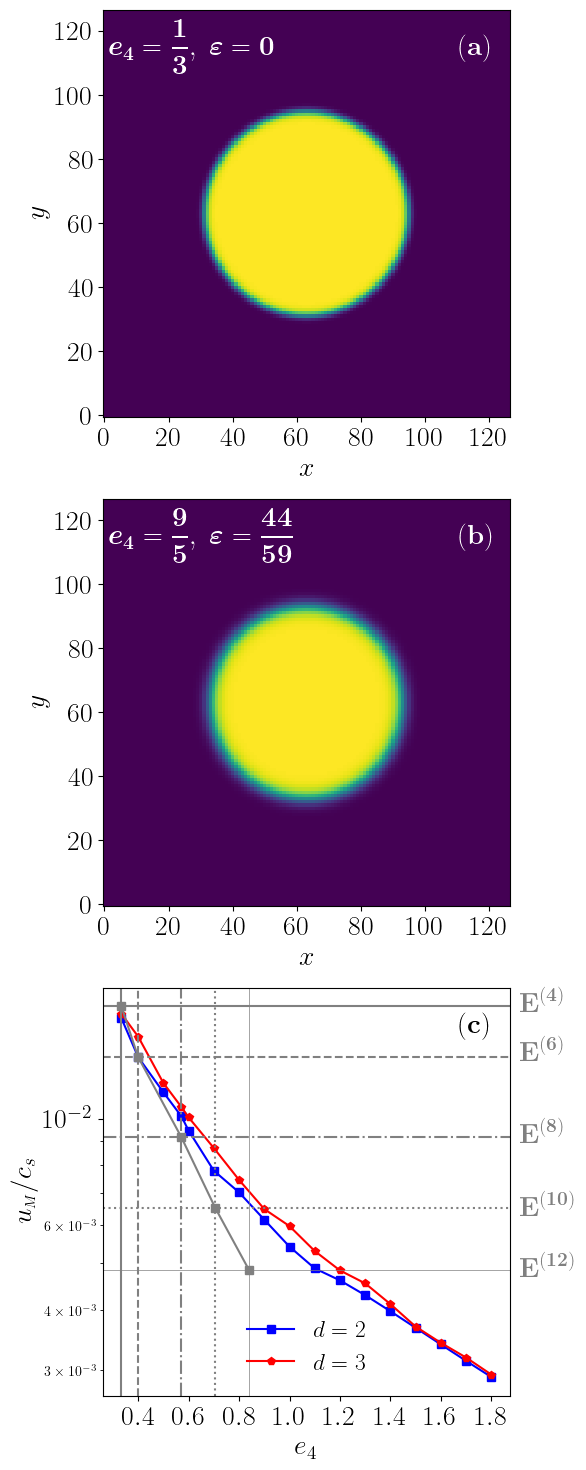

In [9]:
plt_maxu_2d, plt_maxu_3d = results_sims_dict['plt_maxu_2d'], results_sims_dict['plt_maxu_3d']
e4_values = np.sort(np.array([sp.Rational(k, 10) for k in range(4, 18 + 1)] + [sp.Rational(1, 3), sp.Rational(4, 7)]))

root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

print(rcParams['text.latex.preamble'])

SetMatplotlibLatexParamas([rc], [rcParams])
# rcParams['text.latex.preamble']='\\usepackage{amsmath}'
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

nx_fig, ny_fig = 1, 3

mult = 1.5
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=3.5 * mult, _y_size=4 * mult)

if True:
    ax_n0 = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)
    ax_n0.imshow(n_fields_2d[0], origin='lower')
    ax_n0.set_xlabel('$x$', fontsize = fs)
    ax_n0.set_ylabel('$y$', fontsize = fs)

    SetAxPanelLabel(ax=ax_n0, label='$$ \\boldsymbol{e_4}=\\mathbf{\\frac{1}{3}},\;\\boldsymbol{\\varepsilon} = \mathbf{0}$$', 
                    fs=fs, color='white', x_pos = 0.015, y_pos = 0.89)
    SetAxPanelLabel(ax=ax_n0, label='$\mathbf{(a)}$', 
                    fs=fs, color='white', x_pos = 0.875, y_pos = 0.89)    
    # SetAxPanelLabel(ax=ax_n0, label='$$ \\boldsymbol{\\xi} $$', fs=fs, color='white')

    for tick in ax_n0.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_n0.get_yticklabels():
        tick.set_fontsize(fs)

if True:
    ax_n1 = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)
    ax_n1.imshow(n_fields_2d[-1], origin='lower')
    ax_n1.set_xlabel('$x$', fontsize = fs)
    ax_n1.set_ylabel('$y$', fontsize = fs)

    SetAxPanelLabel(ax=ax_n1, label='$$ \\boldsymbol{e_4}=\mathbf{\\frac{9}{5}},\;\\boldsymbol{\\varepsilon} = \mathbf{\\frac{44}{59}}$$', 
                    fs=fs, color='white', x_pos = 0.015, y_pos = 0.89)
    SetAxPanelLabel(ax=ax_n1, label='$\mathbf{(b)}$', 
                    fs=fs, color='white', x_pos = 0.875, y_pos = 0.89)    

    for tick in ax_n1.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_n1.get_yticklabels():
        tick.set_fontsize(fs)

if True:
    ## Need to simulate this values as well!
    u_max_D2E4 = np.mean(results_sims_dict['D2E4'])
    u_max_D2E6 = np.mean(results_sims_dict['D2E6'])
    u_max_D2E8 = np.mean(results_sims_dict['D2E8'])
    u_max_D2E10 = np.mean(results_sims_dict['D2E10'])
    u_max_D2E12 = np.mean(results_sims_dict['D2E12'])

    # u_max_D2E4 = 0.017143
    # u_max_D2E6 = 0.01343932
    # u_max_D2E8 = 0.0091465
    # u_max_D2E10 = 0.00651546
    # u_max_D2E12 = 0.00484344

    all_iso_data_u_max = [u_max_D2E4, u_max_D2E6, u_max_D2E8, u_max_D2E10, u_max_D2E12]
    all_iso_data_e4 = [1/3, 2/5, 4/7, 12/17, 120/143]

    ax_umax = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)
    ax_umax.plot(e4_values, plt_maxu_2d, marker='s', color='blue', label='$d=2$')
    ax_umax.plot(e4_values, plt_maxu_3d, marker='p', color='red', label='$d=3$')

    ax_umax.set_xlabel('$e_4$', fontsize = fs)
    ax_umax.set_ylabel('$u_{\\scriptscriptstyle{M}} / c_s$', fontsize = fs)

    ax_umax.set_yscale('log')
    ax_umax.legend(frameon = False, loc = 'lower center')

    ax_umax.axvline(x=1/3, color='grey', linestyle='-')
    ax_umax.axhline(y=u_max_D2E4, color='grey', linestyle='-')
    ax_umax.plot([1/3], [u_max_D2E4], marker='s', color='gray')

    ax_umax.axvline(x=2/5, color='grey', linestyle='--')
    ax_umax.axhline(y=u_max_D2E6, color='grey', linestyle='--')
    ax_umax.plot([2/5], [u_max_D2E6], marker='s', color='gray')

    ax_umax.axvline(x=4/7, color='grey', linestyle='-.')
    ax_umax.axhline(y=u_max_D2E8, color='grey', linestyle='-.')
    ax_umax.plot([4/7], [u_max_D2E8], marker='s', color='gray')

    ax_umax.axvline(x=12/17, color='grey', linestyle=':')
    ax_umax.axhline(y=u_max_D2E10, color='grey', linestyle=':')
    ax_umax.plot([12/17], [u_max_D2E10], marker='s', color='gray')

    ax_umax.axvline(x=120/143, color='grey', linestyle='-', linewidth=0.5)
    ax_umax.axhline(y=u_max_D2E12, color='grey', linestyle='-', linewidth=0.5)
    ax_umax.plot([120/143], [u_max_D2E12], marker='s', color='gray')

    ax_umax.plot(all_iso_data_e4, all_iso_data_u_max, color='gray')

    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(4)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.94)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(6)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.82)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(8)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.62)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(10)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.44)
    SetAxPanelLabel(ax=ax_umax, label='$$ \\mathbf{E^{(12)}}$$', 
                    fs=fs, color='gray', x_pos = 1.025, y_pos = 0.29)
    SetAxPanelLabel(ax=ax_umax, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.875, y_pos = 0.89)    

    for tick in ax_umax.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_umax.get_yticklabels():
        tick.set_fontsize(fs)

plt.savefig(root_dir_fig / 'u_max_e4.pdf', bbox_inches = 'tight', dpi = 300)

## Table II

In [10]:
"""
Computing custom stencils: 3d
"""

it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 2, 0)],
                                        l2_list_2d = [1, 2, 4, 5, 8])

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)]])



sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

"""
Computing custom stencils: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 8])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 4 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0]])

"""
Two-dimensional case
"""
w_sol_2d = it2d_custom_reference.w_sol[0]
w_sol_2d_iso_dict = it2d_custom_reference.GetStdIsoDict()
e4_2d_sol = sp.solve(sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]), [it2d_custom_reference.e_sym[4]])[0]
W_2d = {l2: sp.Symbol('W(' + str(l2) + ')') for l2 in it2d_custom_reference.l2_list}

W_2d_sigma = {}
for k, w in enumerate(w_sol_2d):
    w_subs = w.subs({it2d_custom_reference.e_sym[4]: e4_2d_sol})
    w_subs = w_subs.subs(w_sol_2d_iso_dict)
    W_2d_sigma[it2d_custom_reference.l2_list[k]] = sp.latex(w_subs)


"""
Three-dimensional case
"""
w_sol_3d = it3d_custom_reference.tuning_w_sol_list_3d
w_sol_3d_iso_dict = it3d_custom_reference.GetStdIsoDict()

l2_list_3d = np.sum(np.array(it3d_custom_reference.root_vectors_3d) ** 2, axis=1).tolist()
W_3d = {l2: sp.Symbol('W(' + str(l2) + ')') for l2 in l2_list_3d}

"""
We can use the same solution as in the two-dimensional case because the 3d stencil exactly projects on the 2d one
"""
W_3d_sigma = {}
for k, w in enumerate(w_sol_3d):
    w_subs = w.subs({it3d_custom_reference.e_sym[4]: e4_2d_sol})
    w_subs = w_subs.subs(w_sol_3d_iso_dict)
    W_3d_sigma[l2_list_3d[k]] = sp.latex(w_subs)

# W_2d, W_2d_sigma, W_3d, W_3d_sigma

## Generating the table

from IPython.display import display, Latex

N_2d = len(it2d_custom_reference.GetWeightsStencilSol({}).PushStencil()['Es'])
N_3d = len(it3d_custom_reference.GetWeightsStencilSol3D({})['XIs'])

table_II = r"""
\begin{array}{lcc}
& d = 2 & d = 3 \\""" + r""" &  & \\ 
\hline \\
""" + str(W_3d[1]) + r""" & """ + W_2d_sigma[1] + r""" & """ + W_3d_sigma[1] + r""" \\
""" + str(W_3d[2]) + r""" & """ + W_2d_sigma[2] + r""" & """ + W_3d_sigma[2] + r""" \\
""" + str(W_3d[3]) + r""" & - & """ + W_3d_sigma[3] + r""" \\
""" + str(W_3d[4]) + r""" & """ + W_2d_sigma[4] + r""" & """ + W_3d_sigma[4] + r""" \\
""" + str(W_3d[8]) + r""" & """ + W_2d_sigma[8] + r""" & """ + W_3d_sigma[8] + r""" \\
N_e & """ + str(N_2d) + r""" & """ + str(N_3d) + r""" \\
\end{array}
"""

display(Latex(table_II))
print(table_II)

<IPython.core.display.Latex object>


\begin{array}{lcc}
& d = 2 & d = 3 \\ &  & \\ 
\hline \\
W(1) & \frac{4 \hat{\sigma}_0}{3} + \frac{8}{15} & \frac{2 \hat{\sigma}_0}{3} + \frac{4}{15} \\
W(2) & \frac{1}{15} - \frac{\hat{\sigma}_0}{6} & \frac{\hat{\sigma}_0}{3} + \frac{2}{15} \\
W(3) & - & - \frac{\hat{\sigma}_0}{4} - \frac{1}{30} \\
W(4) & - \frac{5 \hat{\sigma}_0}{24} - \frac{1}{30} & - \frac{\hat{\sigma}_0}{6} - \frac{1}{40} \\
W(8) & - \frac{\hat{\sigma}_0}{48} - \frac{1}{240} & - \frac{\hat{\sigma}_0}{48} - \frac{1}{240} \\
N_e & 16 & 44 \\
\end{array}



## Results V.B: Higher-order surface tension tuning - $\hat{\sigma}_1$

In [11]:
# Relevant Thermodynamics Functions

from scipy.interpolate import UnivariateSpline

def SpinodalPsi(G, psi_sym, n_sym, n_min = 1e-4, n_max = 10):
    dpsi_sym = sp.diff(psi_sym, (n_sym, 1))
    psi_f = sp.lambdify([n_sym], psi_sym)
    dpsi_f = sp.lambdify([n_sym], dpsi_sym)
    n_range = np.linspace(n_min, n_max, 2 ** 13)
    dpsi_0_spl = UnivariateSpline(n_range, 1 / 3 + G * psi_f(n_range) * dpsi_f(n_range), s=0)
    n_spin = dpsi_0_spl.roots()
    # return n_spin, n_range, dpsi_0_spl
    return n_spin


def FindDensityFromPressure(G, psi_sym, n_sym, p_target, n_s_values, branch='n_g', exp_2 = 8, n_max = 10):
    n_s_vals = n_s_values
    psi_f = sp.lambdify([n_sym], psi_sym)

    if branch == 'n_g':
        n_s = n_s_vals[0]
        n_range = np.linspace(1e-4, n_s, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

    if branch == 'n_l':
        n_s = n_s_vals[1]
        n_range = np.linspace(n_s, n_max, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

def FindBulkDensitiesDropletLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

def FindBulkDensitiesBubbleLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

from scipy.optimize import newton

def MaxwellEqualAreaIntegral(p0_val, G_val, psi_sym, n_sym, ns_g, ns_l, pb_lam, exp_2 = 10):
    ng_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_g', exp_2 = 10, n_max=4)
    nl_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_l', exp_2 = 10, n_max=4)
    n_fine_adapted = np.linspace(ng_p0, nl_p0, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MyNewton(p_min, p_max, MEAInteg_lam, accuracy = 1e-10):
    print(p_min, p_max, MEAInteg_lam(p_min), MEAInteg_lam(p_max))
    steps_count = 0
    MI_min, MI_max = MEAInteg_lam(p_min), MEAInteg_lam(p_max)
    while np.abs(MEAInteg_lam((p_min + p_max) * 0.5)) > accuracy:
        new_p = (p_min + p_max) * 0.5
        new_MI = MEAInteg_lam(new_p)
        steps_count += 1
        if new_MI * MI_min > 0:
            MI_min, p_min = new_MI, new_p
        else:
            MI_max, p_max = new_MI, new_p
    return (p_min + p_max) * 0.5, steps_count

"""
Psi profile: always assuming Eq. 
"""
def MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2 = 10):
    n_fine_adapted = np.linspace(ng_val, n_val, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MaxwellProfilePsiD2(n_val, ng_val, p0_val, eps_val, G_val, pb_lam, exp_2 = 10):
    return ((8 * (1 - float(eps_val)) / G_val) * (n_val / (float(eps_val) + n_val)) * \
            MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2))


def GetPsiProfile(delta_n, psi_sym, n_sym, eq_params, kickstart = 1e-1):
    psi_f = sp.lambdify([n_sym], psi_sym)
    psi_prime = sp.diff(psi_sym, (n_sym, 1))
    psi_prime_f = sp.lambdify([n_sym], psi_prime)
    n_range_width = eq_params['n_l'] * (1 - kickstart) - eq_params['n_g'] * (1 + kickstart)
    print(int(n_range_width / delta_n))
    n_range = np.linspace(eq_params['n_l'] * (1 - kickstart), eq_params['n_g'] * (1 + kickstart), int(n_range_width / delta_n))
    dn = np.abs(n_range[1] - n_range[0])
    dx_s = []
    for n_val in n_range:
        # print(np.sqrt(np.float64(dpsi2_lam(n_val))))
        dx_s += [dn * psi_prime_f(n_val) / np.sqrt(np.float64(dpsi2_lam(n_val)))]
    dx_s = np.array(dx_s)
    x_range = np.array([np.sum(dx_s[:i]) for i in range(len(dx_s))])
    return x_range, psi_f(n_range), n_range


### Table III

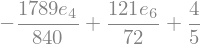

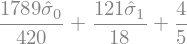

- \frac{1789 e_{4}}{840} + \frac{121 e_{6}}{72} + \frac{4}{5}
\frac{1789 \hat{\sigma}_0}{420} + \frac{121 \hat{\sigma}_1}{18} + \frac{4}{5}



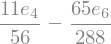

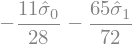

\frac{11 e_{4}}{56} - \frac{65 e_{6}}{288}
- \frac{11 \hat{\sigma}_0}{28} - \frac{65 \hat{\sigma}_1}{72}



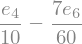

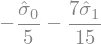

\frac{e_{4}}{10} - \frac{7 e_{6}}{60}
- \frac{\hat{\sigma}_0}{5} - \frac{7 \hat{\sigma}_1}{15}



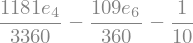

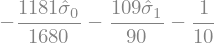

\frac{1181 e_{4}}{3360} - \frac{109 e_{6}}{360} - \frac{1}{10}
- \frac{1181 \hat{\sigma}_0}{1680} - \frac{109 \hat{\sigma}_1}{90} - \frac{1}{10}



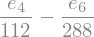

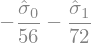

\frac{e_{4}}{112} - \frac{e_{6}}{288}
- \frac{\hat{\sigma}_0}{56} - \frac{\hat{\sigma}_1}{72}



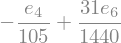

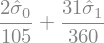

- \frac{e_{4}}{105} + \frac{31 e_{6}}{1440}
\frac{2 \hat{\sigma}_0}{105} + \frac{31 \hat{\sigma}_1}{360}



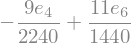

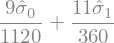

- \frac{9 e_{4}}{2240} + \frac{11 e_{6}}{1440}
\frac{9 \hat{\sigma}_0}{1120} + \frac{11 \hat{\sigma}_1}{360}



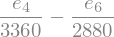

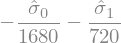

\frac{e_{4}}{3360} - \frac{e_{6}}{2880}
- \frac{\hat{\sigma}_0}{1680} - \frac{\hat{\sigma}_1}{720}



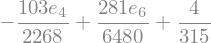

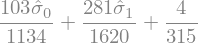

- \frac{103 e_{4}}{2268} + \frac{281 e_{6}}{6480} + \frac{4}{315}
\frac{103 \hat{\sigma}_0}{1134} + \frac{281 \hat{\sigma}_1}{1620} + \frac{4}{315}



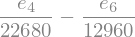

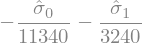

\frac{e_{4}}{22680} - \frac{e_{6}}{12960}
- \frac{\hat{\sigma}_0}{11340} - \frac{\hat{\sigma}_1}{3240}



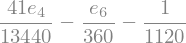

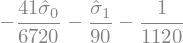

\frac{41 e_{4}}{13440} - \frac{e_{6}}{360} - \frac{1}{1120}
- \frac{41 \hat{\sigma}_0}{6720} - \frac{\hat{\sigma}_1}{90} - \frac{1}{1120}



In [12]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D

it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), 
                                         (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), 
                                         (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                         l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])

def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr
    
it3d_custom_reference.DefineWeights3DTYP0(From2DTO3D_Final)

sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.e6_3d - it3d_custom_reference.e_sym[6], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)], 
                                                it3d_custom_reference.I80_3d - it3d_custom_reference.I_sym[(8, 0)], 
                                                it3d_custom_reference.I81_3d - it3d_custom_reference.I_sym[(8, 1)], 
                                                it3d_custom_reference.I82_3d - it3d_custom_reference.I_sym[(8, 2)], 
                                                it3d_custom_reference.I101_3d - it3d_custom_reference.I_sym[(10, 1)], 
                                                it3d_custom_reference.I102_3d - it3d_custom_reference.I_sym[(10, 2)]])

sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)

eqs = [sp.Eq(it3d_custom_reference.hat_sigma_0_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_custom_reference.hat_sigma_1_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[1])]

sol_hats_dict = sp.solve(eqs, [it3d_custom_reference.e_sym[4], it3d_custom_reference.e_sym[6]])
iso_dict = it3d_custom_reference.GetStdIsoDict()

_ = it3d_custom_reference.GetWeightsStencilSol3D({})

for w in it3d_custom_reference.w_sol_iso_list:
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

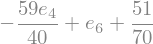

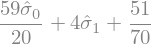

- \frac{59 e_{4}}{40} + e_{6} + \frac{51}{70}
\frac{59 \hat{\sigma}_0}{20} + 4 \hat{\sigma}_1 + \frac{51}{70}



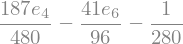

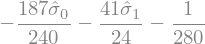

\frac{187 e_{4}}{480} - \frac{41 e_{6}}{96} - \frac{1}{280}
- \frac{187 \hat{\sigma}_0}{240} - \frac{41 \hat{\sigma}_1}{24} - \frac{1}{280}



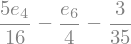

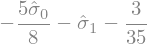

\frac{5 e_{4}}{16} - \frac{e_{6}}{4} - \frac{3}{35}
- \frac{5 \hat{\sigma}_0}{8} - \hat{\sigma}_1 - \frac{3}{35}



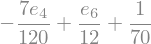

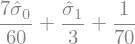

- \frac{7 e_{4}}{120} + \frac{e_{6}}{12} + \frac{1}{70}
\frac{7 \hat{\sigma}_0}{60} + \frac{\hat{\sigma}_1}{3} + \frac{1}{70}



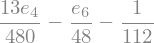

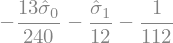

\frac{13 e_{4}}{480} - \frac{e_{6}}{48} - \frac{1}{112}
- \frac{13 \hat{\sigma}_0}{240} - \frac{\hat{\sigma}_1}{12} - \frac{1}{112}



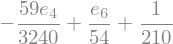

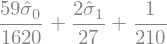

- \frac{59 e_{4}}{3240} + \frac{e_{6}}{54} + \frac{1}{210}
\frac{59 \hat{\sigma}_0}{1620} + \frac{2 \hat{\sigma}_1}{27} + \frac{1}{210}



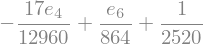

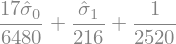

- \frac{17 e_{4}}{12960} + \frac{e_{6}}{864} + \frac{1}{2520}
\frac{17 \hat{\sigma}_0}{6480} + \frac{\hat{\sigma}_1}{216} + \frac{1}{2520}



In [13]:
"""
Defining the custom reference stencil: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 6 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0], 
     it2d_custom_reference.I_sym[(8,1)] - it2d_custom_reference.typ_eq_s[8][1]])

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1])]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

for w in it2d_custom_reference.GetWeightsStencilSol({}).w_sol[0]:
#     display(w.subs({}))
#     print(sp.latex(w))
#     print()
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Simulations

#### Preparing simulations variables

In [14]:
e4_val = sp.Rational(1, 3)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))

n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [15]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D

"""
Defining the custom reference stencil: 3d
"""
print("Computing custom stencil: 3d")
it3d_custom_reference = \
    InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), 
                                         (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), 
                                         (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                         l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])

def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr
    
it3d_custom_reference.DefineWeights3DTYP0(From2DTO3D_Final)

## Check if needed...
sol_ws_dict = \
    it3d_custom_reference.DefineWeights3D(eq_s=[it3d_custom_reference.e2_3d - it3d_custom_reference.e_sym[2], 
                                                it3d_custom_reference.e4_3d - it3d_custom_reference.e_sym[4], 
                                                it3d_custom_reference.e6_3d - it3d_custom_reference.e_sym[6], 
                                                it3d_custom_reference.I40_3d - it3d_custom_reference.I_sym[(4, 0)], 
                                                it3d_custom_reference.I60_3d - it3d_custom_reference.I_sym[(6, 0)], 
                                                it3d_custom_reference.I61_3d - it3d_custom_reference.I_sym[(6, 1)], 
                                                it3d_custom_reference.I80_3d - it3d_custom_reference.I_sym[(8, 0)], 
                                                it3d_custom_reference.I81_3d - it3d_custom_reference.I_sym[(8, 1)], 
                                                it3d_custom_reference.I82_3d - it3d_custom_reference.I_sym[(8, 2)], 
                                                it3d_custom_reference.I101_3d - it3d_custom_reference.I_sym[(10, 1)], 
                                                it3d_custom_reference.I102_3d - it3d_custom_reference.I_sym[(10, 2)]])

sol_ws_list = [sol_ws_dict[w] for w in sol_ws_dict]
it3d_custom_reference.PushWeights3D(sol_ws_list)
## Check if needed...up to here

eqs = [sp.Eq(it3d_custom_reference.hat_sigma_0_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_custom_reference.hat_sigma_1_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[1])]

sol_hats_dict = sp.solve(eqs, [it3d_custom_reference.e_sym[4], it3d_custom_reference.e_sym[6]])
iso_dict = it3d_custom_reference.GetStdIsoDict()

## Check if needed...
_ = it3d_custom_reference.GetWeightsStencilSol3D({})
## Check if needed...up to here

"""
Defining the custom reference stencil: 2d
"""
print("Computing custom stencil: 2d")
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 6 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0], 
     it2d_custom_reference.I_sym[(8,1)] - it2d_custom_reference.typ_eq_s[8][1]])

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1])]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

"""
The reference values are valid both for the 2d and the 3d cases:
the 3d stencil exactly projects onto the 2d one
"""
hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val})

Computing custom stencil: 3d
Computing custom stencil: 2d


In [ ]:
e6_tuned = 1

tuned_stencil_3d = \
    it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val, 
                                                it3d_custom_reference.e_sym[6]: e6_tuned})

#### $\Delta \hat{T} = 0.1$

In [16]:
from pathlib import Path
root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

eq_prop_dump = root_dir_res / 'eq-prop-Sigma1.json'

G_eps = 0.1

psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

print("Computing/retreiving equilibrium interface properties...")
if not eq_prop_dump.is_file():

    ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)

    MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

    p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
    ng_eq, nl_eq = \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

    print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
    print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

    eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}

    """
    Using a common value for the flat surface tension for initializing the densities
    """
    dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

    dpsi_sym = sp.diff(psi_sym, (n, 1))
    dpsi_lam = sp.lambdify([n], dpsi_sym)
    psi_lam = sp.lambdify([n], psi_sym)

    d2psi_lam = \
        lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                    (8 * ((1 - float(0)) / float(G_val)) * (eq_params['p_0'] - pb_lam(n_val))))

    n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
    print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
    dn_int = np.abs(n_range[1] - n_range[0])

    Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
    Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

    eq_params['Sigma_11'] = Sigma_11
    eq_params['Sigma_22'] = Sigma_22

    sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
    eq_params['sigma_f'] = sigma_flat_value

    print()
    print("sigma_f:", eq_params['sigma_f'])
    print()

    # x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
    # dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
    # d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

    # eq_params['x_range'], eq_params['psi_range'], eq_params['n_range'] = \
    #     x_range, psi_range, n_range
    # eq_params['dpsi_analytical'] = dpsi_analytical
    # eq_params['d2psi_analytical'] = d2psi_analytical

    from idpy.Utils.DictHandle import RunThroughDict, Edit_AllFloat, Edit_NPArrayToList
    RunThroughDict(eq_params, edit_function=Edit_AllFloat)
    # RunThroughDict(eq_params, edit_function=Edit_NPArrayToList)

    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(eq_prop_dump))
    md.PushData(data=eq_params, key='eq_params_0.1')
    md.DumpJson(indent=4)

else:
    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(eq_prop_dump))
    md.ReadJson()
    eq_params = md.PullData(key='eq_params_0.1')

    # from idpy.Utils.DictHandle import RunThroughDict, Edit_ListToNPArray
    # RunThroughDict(eq_params, edit_function=Edit_ListToNPArray)

G_val = eq_params['G_c'] * (G_eps + 1)
Sigma_11 = eq_params['Sigma_11']
Sigma_22 = eq_params['Sigma_22']

dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                (8 * ((1 - float(0)) / float(G_val)) * (eq_params['p_0'] - pb_lam(n_val))))

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

Pseudopotential:



Critical coupling: -exp(2)/3 Critical density: 1
Computing/retreiving equilibrium interface properties...
22989


#### Flat-Interface Simulations

In [17]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

CUDA Found!

CUDA GPU[0]
Name :  NVIDIA A100-SXM4-80GB
Memory :  84974239744
DrvVersion :  (12, 4, 0)


OpenCL Found!

Listing GPUs:

Listing CPUs:
OpenCL CPU[0]
Name :  pthread-Intel(R) Xeon(R) Platinum 8468
Memory :  2161827287040
Double :  191
DrvVersion :  1.8


CTypes Found!

Listing CPUs:
Device: CPU Intel(R) Xeon(R) Platinum 8468 Memory:2163974770688




In [18]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [19]:
from pathlib import Path
from InterfaceTuning import InterfaceTuningSims

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatSigma1(n_field, dim_sizes, stencil, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]

    """
    Getting Sigmas and Deltas to show the change in the higher order properties of the interface
    """
    xr_fine_sigma, dx_psi_2, Sigma0 = GetSigma0(n_strip, psi_sym, n_sym)
    xr_fine_sigma, d2x_psi_2, Sigma1 = GetSigma1(n_strip, psi_sym, n_sym)

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)

    return {'x_range': np.arange(len(p_n)), 'p_n': p_nmt_spl, 'sigma_p_nmt': sigma_p_nmt, 
            'Sigma0': Sigma0, 'Sigma1': Sigma1}


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25,
               -0.05, -0.1, -0.15, -0.2, -0.25]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    G = float(G_val)

    dim_sizes = (128, 32) ## 64-bits
    # dim_sizes = (128, 128) ## 32-bits

    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

reproduced-results/Sigma1Tuning_0.1000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9991332576421781 \delta n_l: 0.9995608587233766
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x7fd6485cfa00>
sigma_p_nmt 0.00963884645395127
Sigma0 0.02226162538381882
Sigma1 0.003839809279227443
reproduced-results/Sigma1Tuning_0.1000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 1.0005041370209566 \delta n_l: 1.0002541248930592
(0

#### Two-dimensional bubbles/droplets Simulations

In [20]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

CUDA Found!

CUDA GPU[0]
Name :  NVIDIA A100-SXM4-80GB
Memory :  84974239744
DrvVersion :  (12, 4, 0)


OpenCL Found!

Listing GPUs:

Listing CPUs:
OpenCL CPU[0]
Name :  pthread-Intel(R) Xeon(R) Platinum 8468
Memory :  2161827287040
Double :  191
DrvVersion :  1.8


CTypes Found!

Listing CPUs:
Device: CPU Intel(R) Xeon(R) Platinum 8468 Memory:2163974770688




In [21]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [22]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

# def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
#     name_str = "Sigma1Tuning" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
#     return name_str + '.hdf5'

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

L_list_2d = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]
DParams_list_2d = [0, 0.2, -0.2, 0.15, -0.15, 0.1, -0.1, 0.05, -0.05]

from InterfaceTuning import InterfaceTuningSims

bursted_dict = {}
for L in L_list_2d:
    dim_sizes = (L,) * 2

    for DSigma in DParams_list_2d:
        e6_tuned = e6_val + 4 * prefactor * DSigma

        tuned_stencil_2d = \
            it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                        it2d_custom_reference.e_sym[6]: e6_tuned})

        for interface_kind in ['bubble', 'droplet']:
            print()
            print("-------------------------------")
            print(interface_kind, DSigma, dim_sizes)
            print("-------------------------------")
            print()
            G = float(G_val)

            ## Need to set the densities using Laplace's law
            closed_density_fs = \
                FindBulkDensitiesDropletLaplace if interface_kind == 'droplet' else \
                FindBulkDensitiesBubbleLaplace
            
            closed_densities = \
                closed_density_fs(d=len(dim_sizes), 
                                  R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                  eq_params=eq_params,
                                  n_s_values=n_s_lambdas[psis[0]](float(G_val)), 
                                  sigma_pref = 1)
 
            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, interface_kind))
            print(dump_file_name, dump_file_name.is_file())

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

                bursted_dict[(L, DSigma, interface_kind)] = IT_sim.Run2D(
                    f_stencil=tuned_stencil_2d.PushStencil(),
                    n_g=closed_densities['n_g'], n_l=closed_densities['n_l'],
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
                    dump_name=dump_file_name, kind=interface_kind, delta_strip=3)



-------------------------------
bubble 0 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.0000_(41, 41)_bubble.hdf5 True

-------------------------------
droplet 0 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.0000_(41, 41)_droplet.hdf5 True

-------------------------------
bubble 0.2 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.2000_(41, 41)_bubble.hdf5 True

-------------------------------
droplet 0.2 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.2000_(41, 41)_droplet.hdf5 True

-------------------------------
bubble -0.2 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_-0.2000_(41, 41)_bubble.hdf5 True

-------------------------------
droplet -0.2 (41, 41)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_-0.2000_(41, 41)_droplet.hdf5 True

-------------------------------
bubble 0.15 (

#### Three-dimensional bubbles/droplets Simulations

In [23]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

# def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
#     name_str = "Sigma1Tuning" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
#     return name_str + '.hdf5'

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

L_list_3d = [47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 255]
DParams_list_3d = [0, 0.15, -0.15, 0.1, -0.1, 0.05, -0.05]

from InterfaceTuning import InterfaceTuningSims

bursted_dict = {}
for L in L_list_3d:
    dim_sizes = (L,) * 3

    for DSigma in DParams_list_3d:
        e6_tuned = e6_val + 4 * prefactor * DSigma

        tuned_stencil_3d = \
            it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val, 
                                                          it3d_custom_reference.e_sym[6]: e6_tuned})

        for interface_kind in ['bubble', 'droplet']:
            print()
            print("-------------------------------")
            print(interface_kind, DSigma, dim_sizes)
            print("-------------------------------")
            print()
            G = float(G_val)

            ## Need to set the densities using Laplace's law
            closed_density_fs = \
                FindBulkDensitiesDropletLaplace if interface_kind == 'droplet' else \
                FindBulkDensitiesBubbleLaplace
            
            closed_densities = \
                closed_density_fs(d=len(dim_sizes), 
                                  R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                  eq_params=eq_params,
                                  n_s_values=n_s_lambdas[psis[0]](float(G_val)), 
                                  sigma_pref = 1)

            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, interface_kind))
            print(dump_file_name, dump_file_name.is_file())

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

                bursted_dict[(L, DSigma, interface_kind)] = IT_sim.Run3D(
                    f_stencil=tuned_stencil_3d,
                    n_g=closed_densities['n_g'], n_l=closed_densities['n_l'],
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
                    dump_name=dump_file_name, kind=interface_kind, delta_strip=4)



-------------------------------
bubble 0 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.0000_(47, 47, 47)_bubble.hdf5 True

-------------------------------
droplet 0 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.0000_(47, 47, 47)_droplet.hdf5 True

-------------------------------
bubble 0.15 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.1500_(47, 47, 47)_bubble.hdf5 True

-------------------------------
droplet 0.15 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_0.1500_(47, 47, 47)_droplet.hdf5 True

-------------------------------
bubble -0.15 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_-0.1500_(47, 47, 47)_bubble.hdf5 True

-------------------------------
droplet -0.15 (47, 47, 47)
-------------------------------

reproduced-results/Sigma1Tuning_0.1000_-0.1500_(47, 47, 47)_droplet.hdf5

### Reading Data - Flat interface

In [24]:
def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

flat_profiles_G0p1 = {}
flat_sigma_G0p1, flat_DSigmas_G0p1 = [], []

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25,
               -0.05, -0.1, -0.15, -0.2, -0.25]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

    flat_profiles_G0p1[DSigma] = n_strip
    flat_sigma_G0p1 += [flat_properties_tune['sigma_p_nmt']]
    flat_DSigmas_G0p1 += [DSigma]

flat_sigma_G0p1, flat_DSigmas_G0p1 = \
    np.array(flat_sigma_G0p1), np.array(flat_DSigmas_G0p1)

reproduced-results/Sigma1Tuning_0.1000_0.0000_(128, 32)_flat.hdf5 True
\delta n_g: 0.9991332576421781 \delta n_l: 0.9995608587233766
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
p_n <scipy.interpolate._fitpack2.InterpolatedUnivariateSpline object at 0x7fd66869c1c0>
sigma_p_nmt 0.00963884645395127
Sigma0 0.02226162538381882
Sigma1 0.003839809279227443
reproduced-results/Sigma1Tuning_0.1000_0.0500_(128, 32)_flat.hdf5 True
\delta n_g: 1.0005041370209566 \delta n_l: 1.0002541248930592
(0

### Reading Data - Two-dimensional bubbles/droplets

In [27]:
from pathlib import Path
from InterfaceTuning import EquimolarRadius

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

def ReadEmptyFlag(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    return md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/empty', class_check_override=True)

root_dir_res = Path('./reproduced-results/')

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

L_list = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]

DParams_list = [0, 0.2, -0.2, 0.15, -0.15, 0.1, -0.1, 0.05, -0.05]

drop2d_laplace_data_Re, drop2d_laplace_data_delta_p = {}, {}
drop2d_maxu_data = {}

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in DParams_list:
    drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma] = [], []
    drop2d_maxu_data[DSigma] = []

    G = float(G_val)

    for L in L_list:
        dim_sizes = (L, L)   
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'droplet'))
        print(dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        # print("empty_sim:", empty_sim)
        if empty_sim == False:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])

            drop2d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            drop2d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius2D()['Re']]
            drop2d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma] = \
        np.array(drop2d_laplace_data_Re[DSigma]), np.array(drop2d_laplace_data_delta_p[DSigma])
    drop2d_maxu_data[DSigma] = np.array(drop2d_maxu_data[DSigma])

print("-------------------------- BUBBLES ---------------------------")

bubb2d_laplace_data_Re, bubb2d_laplace_data_delta_p = {}, {}
bubb2d_maxu_data = {}

for DSigma in DParams_list:
    bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma] = [], []
    bubb2d_maxu_data[DSigma] = []    

    for L in L_list:

        dim_sizes = (L, L)
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'bubble'))
        print(DSigma, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
            bubb2d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            bubb2d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius2D()['Re']]
            bubb2d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma] = \
        np.array(bubb2d_laplace_data_Re[DSigma]), np.array(bubb2d_laplace_data_delta_p[DSigma])
    bubb2d_maxu_data[DSigma] = np.array(bubb2d_maxu_data[DSigma])



reproduced-results/Sigma1Tuning_0.1000_0.0000_(41, 41)_droplet.hdf5 True
L: 41 max_u: 0.0007621667875254643 delta p: 0.0007984504781556601
reproduced-results/Sigma1Tuning_0.1000_0.0000_(43, 43)_droplet.hdf5 True
L: 43 max_u: 0.0007469826334929513 delta p: 0.0007894360587790694
reproduced-results/Sigma1Tuning_0.1000_0.0000_(47, 47)_droplet.hdf5 True
L: 47 max_u: 0.0007648912761815872 delta p: 0.000754702413383046
reproduced-results/Sigma1Tuning_0.1000_0.0000_(51, 51)_droplet.hdf5 True
L: 51 max_u: 0.0007602698108685581 delta p: 0.0007116125169365772
reproduced-results/Sigma1Tuning_0.1000_0.0000_(55, 55)_droplet.hdf5 True
L: 55 max_u: 0.0007420465674435119 delta p: 0.0006681287782097367
reproduced-results/Sigma1Tuning_0.1000_0.0000_(61, 61)_droplet.hdf5 True
L: 61 max_u: 0.0007766459509794268 delta p: 0.0006082329794764862
reproduced-results/Sigma1Tuning_0.1000_0.0000_(63, 63)_droplet.hdf5 True
L: 63 max_u: 0.0007596559194238086 delta p: 0.0005900920302887858
reproduced-results/Sigma1Tun

### Reading Data - Three-dimensional bubbles/droplets

In [29]:
from pathlib import Path
from InterfaceTuning import EquimolarRadius

root_dir_res = Path('./reproduced-results/')

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

def ReadEmptyFlag(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    return md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/empty', class_check_override=True)

L_list = [47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 255]
DParams_list = [0, 0.15, -0.15, 0.1, -0.1, 0.05, -0.05]

drop3d_laplace_data_Re, drop3d_laplace_data_delta_p = {}, {}
drop3d_maxu_data = {}

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in DParams_list:
    drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma] = [], []
    drop3d_maxu_data[DSigma] = []

    G = float(G_val)

    for L in L_list:
        dim_sizes = (L, L, L) 
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'droplet'))
        print(DSigma, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])

            drop3d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            drop3d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius3D()['Re']]
            drop3d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma] = \
        np.array(drop3d_laplace_data_Re[DSigma]), np.array(drop3d_laplace_data_delta_p[DSigma])
    drop3d_maxu_data[DSigma] = np.array(drop3d_maxu_data[DSigma])

print("-------------------------- BUBBLES ---------------------------")
## Dropelts Only

if True:
    bubb3d_laplace_data_Re, bubb3d_laplace_data_delta_p = {}, {}
    bubb3d_maxu_data = {}

    for DSigma in DParams_list:
        bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma] = [], []
        bubb3d_maxu_data[DSigma] = []    

        for L in L_list:

            dim_sizes = (L, L, L)
            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'bubble'))
            print(DSigma, dump_file_name, dump_file_name.is_file())

            empty_sim = ReadEmptyFlag(dump_file_name)
            if empty_sim == False:
                laplace_data_swap = ReadLaplaceData(dump_file_name)
                print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
                bubb3d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
                RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

                bubb3d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius3D()['Re']]
                bubb3d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

        bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma] = \
            np.array(bubb3d_laplace_data_Re[DSigma]), np.array(bubb3d_laplace_data_delta_p[DSigma])
        bubb3d_maxu_data[DSigma] = np.array(bubb3d_maxu_data[DSigma])



0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(47, 47, 47)_droplet.hdf5 True
L: 47 max_u: 0.0006838028573498057 delta p: 0.0015044745344344745
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(51, 51, 51)_droplet.hdf5 True
L: 51 max_u: 0.0007015632312668685 delta p: 0.0014333874687896542
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(55, 55, 55)_droplet.hdf5 True
L: 55 max_u: 0.0007304195477079378 delta p: 0.0013517878796722727
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(61, 61, 61)_droplet.hdf5 True
L: 61 max_u: 0.0007501472914195192 delta p: 0.0012331271649299314
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(63, 63, 63)_droplet.hdf5 True
L: 63 max_u: 0.0007624347514887447 delta p: 0.0011964805616657137
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(77, 77, 77)_droplet.hdf5 True
L: 77 max_u: 0.0007805532736628271 delta p: 0.0009851867624831034
0 reproduced-results/Sigma1Tuning_0.1000_0.0000_(87, 87, 87)_droplet.hdf5 True
L: 87 max_u: 0.0008089673574355585 delta p: 0.00087

### Figure 3

3d DSigma: 0 sigma_fit: 0.0095933565310265
2d DSigma: 0 sigma_fit: 0.009662168706323485
2d DSigma: -0.2 sigma_fit: 0.008321925096799163
2d DSigma: -0.15 sigma_fit: 0.0088432247257936
2d DSigma: -0.1 sigma_fit: 0.00917764542658546
2d DSigma: -0.05 sigma_fit: 0.009440389900940543
2d DSigma: 0.2 sigma_fit: 0.010334580497307382
2d DSigma: 0.15 sigma_fit: 0.010188633705015533
2d DSigma: 0.1 sigma_fit: 0.010030257366820157
2d DSigma: 0.05 sigma_fit: 0.009856348538845755
3d DSigma: -0.15 sigma_fit: 0.008416467292439363
3d DSigma: -0.1 sigma_fit: 0.008989665464281765
3d DSigma: -0.05 sigma_fit: 0.009333774578688576
3d DSigma: 0.15 sigma_fit: 0.01016168327675766
3d DSigma: 0.1 sigma_fit: 0.009994901260470406
3d DSigma: 0.05 sigma_fit: 0.009807594999481372


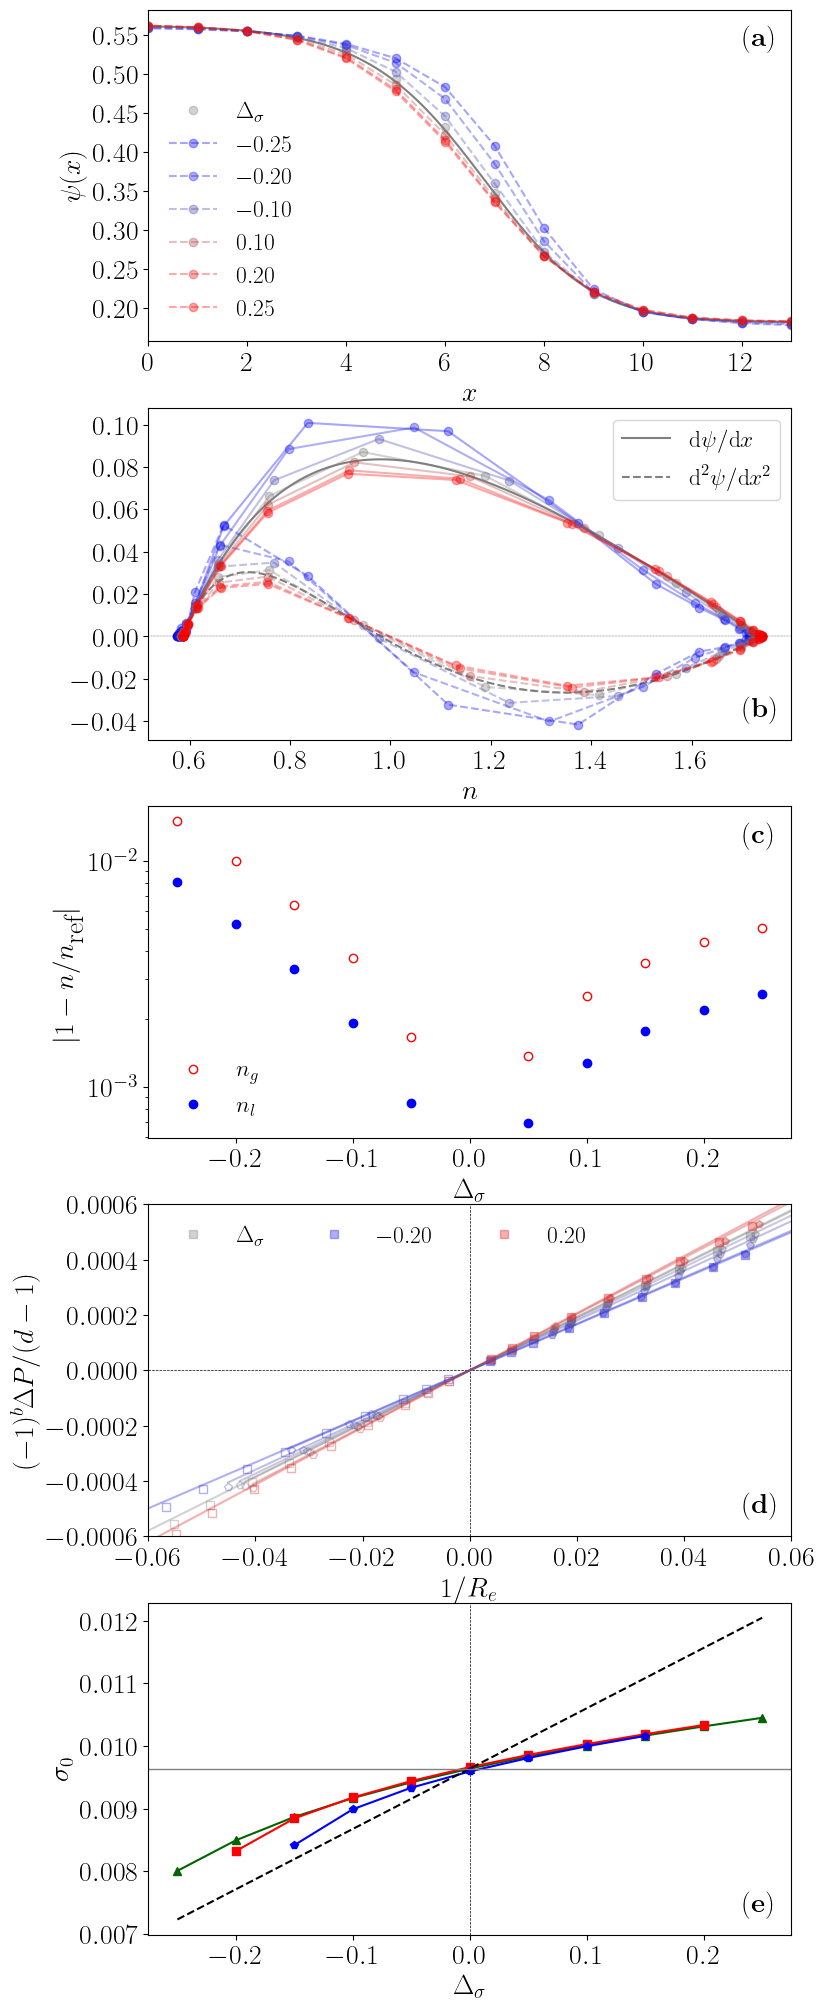

In [30]:
import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

from scipy.optimize import curve_fit

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20
fs, ms_small, ms_large, ms_large_c = 20, 7, 6, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.25)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.25, vmax = 0)

markers = {1: 't', 2: 's', 3: 'p'}
m_opts_drp = {1: {'marker': 't', 'fillstyle': None, 'linestyle': 'none'},
              2: {'marker': 's', 'fillstyle': None, 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': None, 'linestyle': 'none'}}

m_opts_bub = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': 'none'}, 
              2: {'marker': 's', 'fillstyle': 'none', 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': 'none'}}

m_opts_drp_dash = {1: {'marker': 't', 'fillstyle': None, 'linestyle': '--'},
                   2: {'marker': 's', 'fillstyle': None, 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': None, 'linestyle': '--'}}

m_opts_bub_dash = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': '--'}, 
                   2: {'marker': 's', 'fillstyle': 'none', 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': '--'}}

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'

nx_fig, ny_fig = 1, 5

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 87.15, psi_range, color='grey')

    for i, DSigma in enumerate([0][:1]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\sigma$')


    # shifts = {-0.5: -1, -0.4: -1, -0.3: -1, -0.2: 0, -0.1: 0}
    shifts = {-0.25: -0, -0.2: -0, -0.1: 0}
    for i, DSigma in enumerate([-0.25, -0.2, -0.1][:3]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)) + shifts[DSigma], psi_f(n_strip), 
                        marker = 'o', linestyle='--', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DSigma))

    shifts = {0.25: 0, 0.2: 0, 0.1: 0}
    for i, DSigma in enumerate([0.1, 0.2, 0.25][:3]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))
        n_strip = flat_profiles_G0p1[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='--', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DSigma))

    ax_profile.set_xlim([90, 103])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(90, 103, 2), labels=np.arange(0, 103 - 90, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DSigma in enumerate([-0.25, -0.2, -0.1][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

        n_strip = flat_profiles_G0p1[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    for i, DSigma in enumerate([0, 0.1, 0.2, 0.25][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))

        n_strip = flat_profiles_G0p1[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    ax_dd.set_xlabel('$n$', fontsize = fs)
    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p1[0]), np.amax(flat_profiles_G0p1[0])

    for i, DSigma in enumerate([-0.25, -0.2, -0.15, -0.1, -0.05, 
                                0, 
                                0.05, 0.1, 0.15, 0.2, 0.25]):
        ng, nl = np.amin(flat_profiles_G0p1[DSigma]), np.amax(flat_profiles_G0p1[DSigma])
        plt.plot([DSigma], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DSigma], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\sigma$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')
    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

if True:
    #################################################################################
    #################################################################################

    def FitSigma(bubb_re, bubb_delta_p, drop_re, drop_delta_p, dim, fit_cuts=None):
        """
        Now, collect the data point and fit
        """
        sort_index_bubb_re_m1 = np.argsort(-1 / bubb_re)
        sorted_bubb_re = bubb_re[sort_index_bubb_re_m1]
        sorted_bubb_delta_p = -bubb_delta_p[sort_index_bubb_re_m1]

        sort_index_drop_re_m1 = np.argsort(1 / drop_re)
        sorted_drop_re = drop_re[sort_index_drop_re_m1]
        sorted_drop_delta_p = drop_delta_p[sort_index_drop_re_m1]

        joint_re_m1 = np.append(-1  / sorted_bubb_re, 1 / sorted_drop_re)
        joint_delta_p = np.append(sorted_bubb_delta_p, sorted_drop_delta_p)

        """
        Fitting Tolman Length
        """
        fit_cut_index = np.array([True] * len(joint_re_m1))
        if fit_cuts is not None:
            fit_cut_index = np.where((joint_re_m1 > fit_cuts[0]) & (joint_re_m1 < fit_cuts[1]))

        def linear_func(x, b):
            return b * x

        lin_fit, lin_cov = curve_fit(linear_func, joint_re_m1[fit_cut_index], joint_delta_p[fit_cut_index] / (dim - 1))


        return lin_fit[0], np.linspace(joint_re_m1[0], joint_re_m1[-1], 2 ** 10)    
        
    ############# LAPLACE
    sigmas_fit_3d, dsigmas_values_3d = [], []
    sigmas_fit_2d, dsigmas_values_2d = [], []

    if True:
        ax_laplace = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

        if True:
            for i, DSigma in enumerate([0][:]):
                color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=[-0.02, 0.02])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
                            label='$\Delta_\sigma$')
            
            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            
        ax_laplace.axhline(y=0, linestyle='--', color='black', linewidth=0.5)        
        ax_laplace.axvline(x=0, linestyle='--', color='black', linewidth=0.5)        

        for i, DSigma in enumerate([-0.2, -0.15, -0.1, -0.05][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            if DSigma == -0.2:
                ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                                -bubb2d_laplace_data_delta_p[DSigma], 
                                **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
                ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                                drop2d_laplace_data_delta_p[DSigma], 
                                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                                label=get_label(DSigma))

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            if DSigma == -0.2:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        for i, DSigma in enumerate([0.2, 0.15, 0.1, 0.05][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))
            if DSigma == 0.2:
                ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                                -bubb2d_laplace_data_delta_p[DSigma], 
                                **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
                ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                                drop2d_laplace_data_delta_p[DSigma], 
                                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                                label=get_label(DSigma))

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            if DSigma == 0.2:
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ## 0.4, -0.25
        if True:
            fit_cuts = {-0.15: (-0.02, 0.02), -0.1: (-0.02, 0.02), -0.05: (-0.02, 0.02)}
            for i, DSigma in enumerate([-0.15, -0.1, -0.05][:]):
                color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2

                if DSigma == -0.15 or True:
                    ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                    **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                if DSigma == -0.15 or True:
                    ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                    **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=fit_cuts[DSigma])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                if DSigma == -0.15 or True:
                    ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            fit_cuts = {0.15: (-0.02, 0.02), 0.1: (-0.02, 0.02), 0.05: (-0.02, 0.02)}
            for i, DSigma in enumerate([0.15, 0.1, 0.05][:]):
                color = cmap_sigma_up(col_sigma_norm_up(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2

                if DSigma == 0.15:
                    ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                    **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                if DSigma == 0.15:
                    ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                    **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=fit_cuts[DSigma])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                if DSigma == 0.15:
                    ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ax_laplace.legend(frameon = False, loc = 'upper left', ncol=4)

        for tick in ax_laplace.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_laplace.get_yticklabels():
            tick.set_fontsize(fs)

        # ax_laplace.set_ylim([-0.0012, 0.002])
        ax_laplace.set_xlim([-0.06, 0.06])
        ax_laplace.set_ylim([-0.0006, 0.0006])

        # ax_laplace.set_xlim([0, 0.05])
        # ax_laplace.set_ylim([0, 0.0014])

        ax_laplace.set_xlabel('$1 / R_e$', fontsize = fs)
        ax_laplace.set_ylabel('$(-1)^b\Delta P / (d - 1)$', fontsize = fs)

        SetAxPanelLabel(ax=ax_laplace, label='$\mathbf{(d)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 



    sigmas_fit_3d, dsigmas_values_3d = \
        np.array(sigmas_fit_3d), np.array(dsigmas_values_3d)
    sigmas_fit_2d, dsigmas_values_2d = \
        np.array(sigmas_fit_2d), np.array(dsigmas_values_2d)

    dsigmas_values_3d_sindex = np.argsort(dsigmas_values_3d)
    sigmas_fit_3d = sigmas_fit_3d[dsigmas_values_3d_sindex]
    dsigmas_values_3d = dsigmas_values_3d[dsigmas_values_3d_sindex]

    dsigmas_values_2d_sindex = np.argsort(dsigmas_values_2d)
    sigmas_fit_2d = sigmas_fit_2d[dsigmas_values_2d_sindex]
    dsigmas_values_2d = dsigmas_values_2d[dsigmas_values_2d_sindex]

    ################## SIGMA

    sort_deltas_index = np.argsort(flat_DSigmas_G0p1)

    flat_sigma_G0p1 = flat_sigma_G0p1[sort_deltas_index]
    flat_DSigmas_G0p1 = flat_DSigmas_G0p1[sort_deltas_index]

    if True:
        ax_sigma = plt.subplot2grid((ny_fig, nx_fig), (4, 0), colspan = 1, rowspan = 1)

        ref_sigma = flat_sigma_G0p1[np.where(flat_DSigmas_G0p1 == 0)]
        ax_sigma.plot(flat_DSigmas_G0p1, flat_sigma_G0p1, marker='^', color='darkgreen')
        ax_sigma.plot(dsigmas_values_2d, sigmas_fit_2d, marker='s', color='red')
        ax_sigma.plot(dsigmas_values_3d, sigmas_fit_3d, marker='p', color='blue')
        ax_sigma.plot(flat_DSigmas_G0p1, ref_sigma * (1 + flat_DSigmas_G0p1), color='black', linestyle='--')

        ax_sigma.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
        ax_sigma.axhline(y=ref_sigma, linewidth=1, color='gray')

        for tick in ax_sigma.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_sigma.get_yticklabels():
            tick.set_fontsize(fs)

        ax_sigma.set_xlabel('$\Delta_\sigma$', fontsize = fs)
        ax_sigma.set_ylabel('$\sigma_0$', fontsize = fs)

        SetAxPanelLabel(ax=ax_sigma, label='$\mathbf{(e)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 


    # plt.savefig('figures/sigma_0p1.pdf', bbox_inches = 'tight', dpi = 150)

#### $\Delta \hat{T} = 0.2$

In [31]:
G_eps = 0.2

psi_sym = psis[0]
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], 0, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(0) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(0)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

Pseudopotential:



Critical coupling: -exp(2)/3 Critical density: 1
0.11101145550521871 0.14716491429452674 -0.04953608461842109 0.016718667669801224
Check Pressure: 0.13583906683135039 0.13583906683135066 0.13583906683135039
Density ratio: 4.619168982236938 2.1755437021656245 0.4709816225671112
Debug - the derivative values should both be positive - avoid negative square root: 1.07324074907934e-7*exp(-2) 3.56839981878639e-17*exp(-2)

sigma_f: 0.026914950356015162

34048


#### Flat-Interface Simulations

**1m 59s** with **NVIDIA A100-SXM4-80GB** on **CPU Intel(R) Xeon(R) Platinum 8468**

In [32]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

CUDA Found!

CUDA GPU[0]
Name :  NVIDIA A100-SXM4-80GB
Memory :  84974239744
DrvVersion :  (12, 4, 0)


OpenCL Found!

Listing GPUs:

Listing CPUs:
OpenCL CPU[0]
Name :  pthread-Intel(R) Xeon(R) Platinum 8468
Memory :  2161827287040
Double :  191
DrvVersion :  1.8


CTypes Found!

Listing CPUs:
Device: CPU Intel(R) Xeon(R) Platinum 8468 Memory:2163974770688




In [33]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [34]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatSigma1(n_field, dim_sizes, stencil, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]

    """
    Getting Sigmas and Deltas to show the change in the higher order properties of the interface
    """
    xr_fine_sigma, dx_psi_2, Sigma0 = GetSigma0(n_strip, psi_sym, n_sym)
    xr_fine_sigma, d2x_psi_2, Sigma1 = GetSigma1(n_strip, psi_sym, n_sym)

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)

    return {'x_range': np.arange(len(p_n)), 'p_n': p_nmt_spl, 'sigma_p_nmt': sigma_p_nmt, 
            'Sigma0': Sigma0, 'Sigma1': Sigma1}


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

from InterfaceTuning import InterfaceTuningSims

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

reproduced-results/Sigma1Tuning_0.2000_0.0000_(128, 32)_flat.hdf5 False
CUDA:  {'Name': 'NVIDIA A100-SXM4-80GB', 'Device': '0', 'Memory': '84974239744', 'DrvVersion': (12, 4, 0)}
{'PopType': 'double', 'NType': 'double', 'UType': 'double', 'PsiType': 'double', 'ChiType': 'double', 'ThetaType': 'double', 'MuType': 'double', 'SCFType': 'double', 'NoiseType': 'double', 'ForceType': 'double', 'SType': 'int', 'WType': 'double', 'LengthType': 'double', 'FlagType': 'unsigned char'}


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  9.072596870206488e-09 max_u:  2.6847545009267497e-08
Conv! False True
Step: 32768
u_conv:  9.07258651784071e-09 max_u:  3.3336561077378584e-14
Conv! False False
Step: 49152
u_conv:  1.6930247716208643e-14 max_u:  4.339305175693056e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.0000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9964515167521609 \delta n_l: 0.9986908248357629
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  1.1655252269727843e-08 max_u:  3.674376392335896e-08
Conv! False True
Step: 32768
u_conv:  1.1655281194919223e-08 max_u:  1.110669580123101e-13
Conv! False False
Step: 49152
u_conv:  2.7857362328458772e-14 max_u:  4.342288279801374e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.0500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.999262249244522 \delta n_l: 0.9997294088868938
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  1.1718736166039669e-08 max_u:  4.257712871256237e-08
Conv! False True
Step: 32768
u_conv:  1.1718778733122718e-08 max_u:  1.910463923928398e-13
Conv! False False
Step: 49152
u_conv:  4.1884816678050704e-14 max_u:  4.53952210915445e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.1000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.001788157169891 \delta n_l: 1.0006524104675045
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  9.283242723815601e-09 max_u:  3.998610737643918e-08
Conv! False True
Step: 32768
u_conv:  9.283259009687447e-09 max_u:  1.4092613215932057e-13
Conv! False False
Step: 49152
u_conv:  2.277624901046208e-14 max_u:  4.472683412896201e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.1500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.004057292099756 \delta n_l: 1.001474948341914
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  6.598298813684013e-09 max_u:  2.8741859283373415e-08
Conv! False True
Step: 32768
u_conv:  6.598315531813208e-09 max_u:  1.8225429639491484e-13
Conv! False False
Step: 49152
u_conv:  4.0080921207553466e-14 max_u:  4.159317305298772e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.2000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0060597912831253 \delta n_l: 1.0022108564016532
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  5.515664317817854e-09 max_u:  2.226073217043275e-08
Conv! False True
Step: 32768
u_conv:  5.5156570768972105e-09 max_u:  2.498529773933623e-13
Conv! False False
Step: 49152
u_conv:  9.081643223949918e-14 max_u:  4.8740573478543706e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.2500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0078197375564069 \delta n_l: 1.0028737883874683
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  9.199851552153164e-09 max_u:  3.7779199738851386e-08
Conv! False True
Step: 32768
u_conv:  9.199947881375838e-09 max_u:  3.415724216028512e-13
Conv! False False
Step: 49152
u_conv:  9.762104749603237e-14 max_u:  4.416418711177189e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.3000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.009312545931886 \delta n_l: 1.003489259823496
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  1.6433866091503593e-08 max_u:  5.085663479838676e-08
Conv! False True
Step: 32768
u_conv:  1.6433906062684584e-08 max_u:  2.303589737979312e-13
Conv! False False
Step: 49152
u_conv:  6.570728162702068e-14 max_u:  4.4870640418702656e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.3500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0106610283793436 \delta n_l: 1.0040775549223309
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  2.2834859201484485e-08 max_u:  6.445200302406446e-08
Conv! False True
Step: 32768
u_conv:  2.283479106530848e-08 max_u:  2.919482553422995e-13
Conv! False False
Step: 49152
u_conv:  6.828759695402832e-14 max_u:  4.5109074035939726e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.4000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0118830288664424 \delta n_l: 1.0046625816910013
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  2.786396503281625e-08 max_u:  8.584573957518055e-08
Conv! False True
Step: 32768
u_conv:  2.786377016589529e-08 max_u:  5.457854659817757e-13
Conv! False False
Step: 49152
u_conv:  1.9496767019530886e-13 max_u:  4.9039430452056786e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.4500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0129938170766546 \delta n_l: 1.005213585005067
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  3.121941097012619e-08 max_u:  1.0317374809611592e-07
Conv! False True
Step: 32768
u_conv:  3.1219111883618427e-08 max_u:  9.706354965297063e-13
Conv! False False
Step: 49152
u_conv:  3.001367621883138e-13 max_u:  4.9326953273011244e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_0.5000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 1.0140064497249779 \delta n_l: 1.0057711661184385
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  3.5379234229912853e-09 max_u:  1.948856948724243e-08
Conv! False True
Step: 32768
u_conv:  3.5378756095285065e-09 max_u:  1.368279568402803e-13
Conv! False False
Step: 49152
u_conv:  5.0391429161105934e-14 max_u:  4.803874312738653e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.0500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9933240030171475 \delta n_l: 0.9975207776885543
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91 

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  6.441630699719138e-09 max_u:  3.113511765338063e-08
Conv! False True
Step: 32768
u_conv:  6.441613983339823e-09 max_u:  1.4643068079333877e-13
Conv! False False
Step: 49152
u_conv:  2.7639586716920765e-14 max_u:  6.067617374616762e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.1000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9898483991465852 \delta n_l: 0.9962024622516038
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  1.5770509303797593e-08 max_u:  5.6957056913725644e-08
Conv! False True
Step: 32768
u_conv:  1.5770437573038765e-08 max_u:  2.9281013126639863e-13
Conv! False False
Step: 49152
u_conv:  7.286127537697928e-14 max_u:  6.549166011717341e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.1500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9859863435274517 \delta n_l: 0.9947149516325589
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  6.829928184473147e-09 max_u:  2.150838873641273e-08
Conv! False True
Step: 32768
u_conv:  6.829947154827756e-09 max_u:  5.964225850851797e-14
Conv! False False
Step: 49152
u_conv:  4.421528230755524e-14 max_u:  1.0125841468185123e-13
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.2000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9816658074137268 \delta n_l: 0.9930221661628611
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  2.363101960709959e-09 max_u:  8.12986317121556e-09
Conv! False True
Step: 32768
u_conv:  2.3631042577563216e-09 max_u:  4.535205646143775e-14
Conv! False False
Step: 49152
u_conv:  3.769345298245377e-15 max_u:  4.570405571626841e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.2500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.976715965051215 \delta n_l: 0.9910448613697311
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92 

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  2.319670992288308e-08 max_u:  7.127637986806615e-08
Conv! False True
Step: 32768
u_conv:  2.3196695133330865e-08 max_u:  1.676227063224828e-12
Conv! False False
Step: 49152
u_conv:  4.803838246211101e-13 max_u:  7.382558040837161e-14
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.3000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9698719292547965 \delta n_l: 0.9882424840497642
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  8.211220632385517e-05 max_u:  0.00025580684995982726
Conv! False True
Step: 32768
u_conv:  8.211220636549109e-05 max_u:  4.990703549519022e-12
Conv! False False
Step: 49152
u_conv:  1.5342377726534022e-12 max_u:  8.65886404268705e-14
Conv! False False
Step: 65536
u_conv:  7.495003859504075e-14 max_u:  2.465534317170503e-13
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.3500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9638096836437139 \delta n_l: 0.9856920705582364
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  1.3806982066746228e-09 max_u:  5.8688862201615055e-09
Conv! False True
Step: 32768
u_conv:  1.3807015767474677e-09 max_u:  4.7054152794369643e-14
Conv! False False
Step: 49152
u_conv:  5.130858926392824e-14 max_u:  1.5196129870817515e-13
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.4000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9545772195180544 \delta n_l: 0.9816805291700833
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  9

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  4.766252552177822e-07 max_u:  1.5743846824150305e-06
Conv! False True
Step: 32768
u_conv:  4.7665489272290565e-07 max_u:  9.63696746459358e-11
Conv! False False
Step: 49152
u_conv:  2.961557972603467e-11 max_u:  8.410724156639197e-14
Conv! False False
Step: 65536
u_conv:  5.324790023253421e-14 max_u:  1.0830359396877425e-13
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.4500_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9467327414774306 \delta n_l: 0.9781465046089438
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69 

/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(221): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


Step: 16384


/home/ubuntu/idea.deploy/papers/arXiv-2505.23647/../../idpy/IdpyCode/IdpyCode.py:534: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(220): warning #177-D: variable "lpop_0" was declared but never referenced
  const PopType lpop_0 = (*(pop + g_tid + 0 * 4096));
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"


  _kernel_module = cu_SourceModule(self.Code(CUDA_T), options = self.SetMacros(CUDA_T),


u_conv:  2.3058446856978196e-08 max_u:  9.93177634719264e-08
Conv! False True
Step: 32768
u_conv:  2.3059208337038084e-08 max_u:  2.2901048893723456e-12
Conv! False False
Step: 49152
u_conv:  7.733183212274801e-13 max_u:  1.0446204557831309e-13
Conv! True False
Dumping in reproduced-results/Sigma1Tuning_0.2000_-0.5000_(128, 32)_flat.hdf5
Key:  ordering_lambdas not builtin/numpy: not dumped!
Key:  psi_sym not builtin/numpy: not dumped!
Key:  n_sym not builtin/numpy: not dumped!
Key:  ordering not builtin/numpy: not dumped!
\delta n_g: 0.9389020701794344 \delta n_l: 0.9744986177627867
(0, 0)
(1, 1)
(0, 0)
(1, 1)
x_range [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91 

#### Two-dimensional bubbles/droplets Simulations

In [ ]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

In [ ]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

# def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
#     name_str = "Sigma1Tuning" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
#     return name_str + '.hdf5'

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

L_list_2d = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]
DParams_list_2d = [0, 0.5, 0.4, 0.3, 0.2, 0.1, -0.1, -0.2, -0.3, -0.35]

from InterfaceTuning import InterfaceTuningSims

bursted_dict = {}
for L in L_list_2d:
    dim_sizes = (L,) * 2

    for DSigma in DParams_list_2d:
        e6_tuned = e6_val + 4 * prefactor * DSigma

        tuned_stencil_2d = \
            it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                        it2d_custom_reference.e_sym[6]: e6_tuned})

        for interface_kind in ['bubble', 'droplet']:
            print()
            print("-------------------------------")
            print(interface_kind, DSigma, dim_sizes)
            print("-------------------------------")
            print()
            G = float(G_val)

            ## Need to set the densities using Laplace's law
            closed_density_fs = \
                FindBulkDensitiesDropletLaplace if interface_kind == 'droplet' else \
                FindBulkDensitiesBubbleLaplace
            
            closed_densities = \
                closed_density_fs(d=len(dim_sizes), 
                                  R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                  eq_params=eq_params,
                                  n_s_values=n_s_lambdas[psis[0]](float(G_val)), 
                                  sigma_pref = 1)
 
            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, interface_kind))
            print(dump_file_name, dump_file_name.is_file())

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

                bursted_dict[(L, DSigma, interface_kind)] = IT_sim.Run2D(
                    f_stencil=tuned_stencil_2d.PushStencil(),
                    n_g=closed_densities['n_g'], n_l=closed_densities['n_l'],
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
                    dump_name=dump_file_name, kind=interface_kind, delta_strip=3)


#### Three-dimensional bubbles/droplets Simulations

In [ ]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

In [ ]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = OCL_T, 0, 'gpu'

In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

# def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
#     name_str = "Sigma1Tuning" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
#     return name_str + '.hdf5'

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'


prefactor = (hat_sigma_0_ref * Sigma_11 + hat_sigma_1_ref * Sigma_22) / (Sigma_22)

L_list_3d = [47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 255]
DParams_list_3d = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]


from InterfaceTuning import InterfaceTuningSims

bursted_dict = {}
for L in L_list_3d:
    dim_sizes = (L,) * 3

    for DSigma in DParams_list_3d:
        e6_tuned = e6_val + 4 * prefactor * DSigma

        tuned_stencil_3d = \
            it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val, 
                                                          it3d_custom_reference.e_sym[6]: e6_tuned})

        for interface_kind in ['bubble', 'droplet']:
            print()
            print("-------------------------------")
            print(interface_kind, DSigma, dim_sizes)
            print("-------------------------------")
            print()
            G = float(G_val)

            ## Need to set the densities using Laplace's law
            closed_density_fs = \
                FindBulkDensitiesDropletLaplace if interface_kind == 'droplet' else \
                FindBulkDensitiesBubbleLaplace
            
            closed_densities = \
                closed_density_fs(d=len(dim_sizes), 
                                  R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                  eq_params=eq_params,
                                  n_s_values=n_s_lambdas[psis[0]](float(G_val)), 
                                  sigma_pref = 1)

            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, interface_kind))
            print(dump_file_name, dump_file_name.is_file())

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

                bursted_dict[(L, DSigma, interface_kind)] = IT_sim.Run3D(
                    f_stencil=tuned_stencil_3d,
                    n_g=closed_densities['n_g'], n_l=closed_densities['n_l'],
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[0]],
                    dump_name=dump_file_name, kind=interface_kind, delta_strip=4)

## 

### Reading Data - Flat interface

In [ ]:
flat_profiles_G0p2 = {}
flat_sigma_G0p2, flat_DSigmas_G0p2 = [], []

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]:
    e6_tuned = e6_val + 4 * prefactor * DSigma

    tuned_stencil_2d = \
        it2d_custom_reference.GetWeightsStencilSol({it2d_custom_reference.e_sym[4]: e4_val, 
                                                    it2d_custom_reference.e_sym[6]: e6_tuned})

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    n_strip = ReadDensity(dump_file_name, dim_sizes)[0,:]
    n_field = ReadDensity(dump_file_name, dim_sizes)
    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    flat_properties_tune = Analyze2DFlatSigma1(n_field, dim_sizes, tuned_stencil_2d, psi_sym, n)
    for _ in flat_properties_tune:
        print(_, flat_properties_tune[_])

    flat_profiles_G0p2[DSigma] = n_strip
    flat_sigma_G0p2 += [flat_properties_tune['sigma_p_nmt']]
    flat_DSigmas_G0p2 += [DSigma]

flat_sigma_G0p2, flat_DSigmas_G0p2 = \
    np.array(flat_sigma_G0p2), np.array(flat_DSigmas_G0p2)

### Reading Data - Two-dimensional bubbles/droplets

In [ ]:
from pathlib import Path
from InterfaceTuning import EquimolarRadius

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

def ReadEmptyFlag(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    return md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/empty', class_check_override=True)

root_dir_res = Path('./reproduced-results/')

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

L_list = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]
DParams_list = [0, 0.5, 0.4, 0.3, 0.2, 0.1, -0.1, -0.2, -0.3, -0.35]

drop2d_laplace_data_Re, drop2d_laplace_data_delta_p = {}, {}
drop2d_maxu_data = {}

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in DParams_list:
    drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma] = [], []
    drop2d_maxu_data[DSigma] = []

    G = float(G_val)

    for L in L_list:
        dim_sizes = (L, L)   
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'droplet'))
        print(dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        # print("empty_sim:", empty_sim)
        if empty_sim == False or True:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])

            drop2d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            drop2d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius2D()['Re']]
            drop2d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma] = \
        np.array(drop2d_laplace_data_Re[DSigma]), np.array(drop2d_laplace_data_delta_p[DSigma])
    drop2d_maxu_data[DSigma] = np.array(drop2d_maxu_data[DSigma])

print("-------------------------- BUBBLES ---------------------------")

bubb2d_laplace_data_Re, bubb2d_laplace_data_delta_p = {}, {}
bubb2d_maxu_data = {}

for DSigma in DParams_list:
    bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma] = [], []
    bubb2d_maxu_data[DSigma] = []    

    for L in L_list:

        dim_sizes = (L, L)
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'bubble'))
        print(DSigma, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False or True:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
            bubb2d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            bubb2d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius2D()['Re']]
            bubb2d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma] = \
        np.array(bubb2d_laplace_data_Re[DSigma]), np.array(bubb2d_laplace_data_delta_p[DSigma])
    bubb2d_maxu_data[DSigma] = np.array(bubb2d_maxu_data[DSigma])



### Reading Data - Three-dimensional bubbles/droplets

In [ ]:
from pathlib import Path
from InterfaceTuning import EquimolarRadius

def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

def ReadEmptyFlag(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    return md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/empty', class_check_override=True)

root_dir_res = Path('./reproduced-results/')

def GetFileNameSigma1(G_eps, DSigma, dim_sizes, kind):
    name_str = "Sigma1Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DSigma) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

L_list = [47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 255]
DParams_list = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]

drop3d_laplace_data_Re, drop3d_laplace_data_delta_p = {}, {}
drop3d_maxu_data = {}

"""
- Make three simulation values per dimension per temperature: \Delta=0,min,max
- Make more simulations for the flat interface showing profile, bulk densities, and derivatives
"""

for DSigma in DParams_list:
    drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma] = [], []
    drop3d_maxu_data[DSigma] = []

    G = float(G_val)

    for L in L_list:
        dim_sizes = (L, L, L)
        dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'droplet'))
        print(DSigma, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])

            drop3d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

            drop3d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius3D()['Re']]
            drop3d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

    drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma] = \
        np.array(drop3d_laplace_data_Re[DSigma]), np.array(drop3d_laplace_data_delta_p[DSigma])
    drop3d_maxu_data[DSigma] = np.array(drop3d_maxu_data[DSigma])

print("-------------------------- BUBBLES ---------------------------")
## Dropelts Only

if True:
    bubb3d_laplace_data_Re, bubb3d_laplace_data_delta_p = {}, {}
    bubb3d_maxu_data = {}

    for DSigma in DParams_list:
        bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma] = [], []
        bubb3d_maxu_data[DSigma] = []    

        for L in L_list:

            dim_sizes = (L, L, L)
            dump_file_name = root_dir_res / Path(GetFileNameSigma1(np.float64(G_eps), DSigma, dim_sizes, 'bubble'))
            print(DSigma, dump_file_name, dump_file_name.is_file())

            empty_sim = ReadEmptyFlag(dump_file_name)
            if empty_sim == False:
                laplace_data_swap = ReadLaplaceData(dump_file_name)
                print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
                bubb3d_maxu_data[DSigma] += [laplace_data_swap['max_u'][-1]]
                RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])

                bubb3d_laplace_data_Re[DSigma] += [RE.GetEquimolarRadius3D()['Re']]
                bubb3d_laplace_data_delta_p[DSigma] += [laplace_data_swap['delta_p'][-1]]

        bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma] = \
            np.array(bubb3d_laplace_data_Re[DSigma]), np.array(bubb3d_laplace_data_delta_p[DSigma])
        bubb3d_maxu_data[DSigma] = np.array(bubb3d_maxu_data[DSigma])



#### Figure 4

In [ ]:
import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

from scipy.optimize import curve_fit

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20
fs, ms_small, ms_large, ms_large_c = 20, 7, 6, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.5)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.35, vmax = 0)

markers = {1: 't', 2: 's', 3: 'p'}
m_opts_drp = {1: {'marker': 't', 'fillstyle': None, 'linestyle': 'none'},
              2: {'marker': 's', 'fillstyle': None, 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': None, 'linestyle': 'none'}}

m_opts_bub = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': 'none'}, 
              2: {'marker': 's', 'fillstyle': 'none', 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': 'none'}}

m_opts_drp_dash = {1: {'marker': 't', 'fillstyle': None, 'linestyle': '--'},
                   2: {'marker': 's', 'fillstyle': None, 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': None, 'linestyle': '--'}}

m_opts_bub_dash = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': '--'}, 
                   2: {'marker': 's', 'fillstyle': 'none', 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': '--'}}

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'

nx_fig, ny_fig = 1, 5

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 89.25, psi_range, color='grey')

    for i, DSigma in enumerate([0]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\sigma$')


    # shifts = {-0.5: -1, -0.4: -1, -0.3: -1, -0.2: 0, -0.1: 0}
    shifts = {-0.45: -1, -0.3: -1, -0.15: 0}
    for i, DSigma in enumerate([-0.45, -0.3, -0.15][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)) + shifts[DSigma], psi_f(n_strip), 
                        marker = 'o', linestyle='--', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DSigma))

    shifts = {0.45: -1, 0.3: -1, 0.15: 0}
    for i, DSigma in enumerate([0.15, 0.3, 0.45][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))
        n_strip = flat_profiles_G0p2[DSigma]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='--', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DSigma))

    ax_profile.set_xlim([90, 101])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(90, 101, 2), labels=np.arange(0, 101 - 90, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89)     

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DSigma in enumerate([-0.45, -0.3, -0.15][:]):
        color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

        n_strip = flat_profiles_G0p2[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    for i, DSigma in enumerate([0, 0.15, 0.3, 0.45][:]):
        color = cmap_sigma_up(col_sigma_norm_up(DSigma))

        n_strip = flat_profiles_G0p2[DSigma]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    ax_dd.set_xlabel('$n$', fontsize = fs)
    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p2[0]), np.amax(flat_profiles_G0p2[0])
    [0,
               0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]
    for i, DSigma in enumerate([-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 
                                0, 
                                0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
        ng, nl = np.amin(flat_profiles_G0p2[DSigma]), np.amax(flat_profiles_G0p2[DSigma])
        plt.plot([DSigma], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DSigma], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DSigma == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\sigma$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')
    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.89) 

if True:
    #################################################################################
    #################################################################################

    def FitSigma(bubb_re, bubb_delta_p, drop_re, drop_delta_p, dim, fit_cuts=None):
        """
        Now, collect the data point and fit
        """
        sort_index_bubb_re_m1 = np.argsort(-1 / bubb_re)
        sorted_bubb_re = bubb_re[sort_index_bubb_re_m1]
        sorted_bubb_delta_p = -bubb_delta_p[sort_index_bubb_re_m1]

        sort_index_drop_re_m1 = np.argsort(1 / drop_re)
        sorted_drop_re = drop_re[sort_index_drop_re_m1]
        sorted_drop_delta_p = drop_delta_p[sort_index_drop_re_m1]

        joint_re_m1 = np.append(-1  / sorted_bubb_re, 1 / sorted_drop_re)
        joint_delta_p = np.append(sorted_bubb_delta_p, sorted_drop_delta_p)

        """
        Fitting Tolman Length
        """
        fit_cut_index = np.array([True] * len(joint_re_m1))
        if fit_cuts is not None:
            fit_cut_index = np.where((joint_re_m1 > fit_cuts[0]) & (joint_re_m1 < fit_cuts[1]))

        def linear_func(x, b):
            return b * x

        lin_fit, lin_cov = curve_fit(linear_func, joint_re_m1[fit_cut_index], joint_delta_p[fit_cut_index] / (dim - 1))


        return lin_fit[0], np.linspace(joint_re_m1[0], joint_re_m1[-1], 2 ** 10)    
        
    ############# LAPLACE
    sigmas_fit_3d, dsigmas_values_3d = [], []
    sigmas_fit_2d, dsigmas_values_2d = [], []

    # DParams_list = [0, 0.5, 0.4, 0.3, 0.2, 0.1, -0.1, -0.2, -0.3, -0.35]
    # DParams_list = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]


    if True:
        ax_laplace = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

        if True:
            for i, DSigma in enumerate([0][:]):
                color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=[-0.04, 0.04])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

        for i, DSigma in enumerate([0][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
                            label='$\Delta_\sigma$')
            
            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            
        ax_laplace.axhline(y=0, linestyle='--', color='black', linewidth=0.5)        
        ax_laplace.axvline(x=0, linestyle='--', color='black', linewidth=0.5)        

        for i, DSigma in enumerate([-0.35, -0.3, -0.2, -0.1][:]):
            color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                            label=get_label(DSigma) if DSigma == -0.35 else None)

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        for i, DSigma in enumerate([0.1, 0.2, 0.3, 0.4, 0.5][:]):
            color = cmap_sigma_up(col_sigma_norm_up(DSigma))
            ax_laplace.plot(-1 / bubb2d_laplace_data_Re[DSigma], 
                            -bubb2d_laplace_data_delta_p[DSigma], 
                            **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
            ax_laplace.plot(1 / drop2d_laplace_data_Re[DSigma], 
                            drop2d_laplace_data_delta_p[DSigma], 
                            **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                            label=get_label(DSigma) if DSigma == 0.5 else None)

            sigma_fit, fit_linspace = \
                FitSigma(bubb2d_laplace_data_Re[DSigma], bubb2d_laplace_data_delta_p[DSigma], 
                        drop2d_laplace_data_Re[DSigma], drop2d_laplace_data_delta_p[DSigma], 
                        2, fit_cuts=[-0.02, 0.02])
            
            print("2d DSigma:", DSigma, "sigma_fit:", sigma_fit)
            sigmas_fit_2d += [sigma_fit]
            dsigmas_values_2d += [DSigma]
            ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ## 0.4, -0.25
        ## DParams_list = [0, 0.4, 0.35, 0.3, 0.2, 0.1, -0.1, -0.2, -0.25]
        if True:
            fit_cuts = {-0.25: [-0.02, 0.02], -0.2: [-0.02, 0.02], -0.1: [-0.02, 0.02]}
            for i, DSigma in enumerate([-0.25, -0.2, -0.1][:]):
                color = cmap_sigma_dn(col_sigma_norm_dn(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=fit_cuts[DSigma])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

            fit_cuts = {0.1: [-0.02, 0.02], 0.2: [-0.02, 0.02], 0.3: [-0.02, 0.02], 0.35: [-0.02, 0.02]}
            for i, DSigma in enumerate([0.1, 0.2, 0.3, 0.35][:]):
                color = cmap_sigma_up(col_sigma_norm_up(DSigma))

                bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[DSigma]
                bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[DSigma] / 2
                ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                                **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
                
                drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[DSigma]
                drop_3d_delta_p = drop3d_laplace_data_delta_p[DSigma] / 2

                cut_data = drop_3d_re_m1 < 0.06
                drop_3d_re_m1 = drop_3d_re_m1[cut_data]
                drop_3d_delta_p = drop_3d_delta_p[cut_data]

                ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

                sigma_fit, fit_linspace = \
                    FitSigma(bubb3d_laplace_data_Re[DSigma], bubb3d_laplace_data_delta_p[DSigma], 
                            drop3d_laplace_data_Re[DSigma], drop3d_laplace_data_delta_p[DSigma], 
                            3, fit_cuts=fit_cuts[DSigma])
                
                print("3d DSigma:", DSigma, "sigma_fit:", sigma_fit)
                sigmas_fit_3d += [sigma_fit]
                dsigmas_values_3d += [DSigma]
                ax_laplace.plot(fit_linspace, fit_linspace * sigma_fit, color=color, linestyle='-', alpha=0.35)

        ax_laplace.legend(frameon = False, loc = 'upper left', ncol=4)

        for tick in ax_laplace.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_laplace.get_yticklabels():
            tick.set_fontsize(fs)

        # ax_laplace.set_ylim([-0.0012, 0.002])
        ax_laplace.set_xlim([-0.06, 0.06])
        ax_laplace.set_ylim([-0.0018, 0.0014])

        # ax_laplace.set_xlim([0, 0.05])
        # ax_laplace.set_ylim([0, 0.0014])

        ax_laplace.set_xlabel('$1 / R_e$', fontsize = fs)
        ax_laplace.set_ylabel('$(-1)^b\Delta P / (d - 1)$', fontsize = fs)

        SetAxPanelLabel(ax=ax_laplace, label='$\mathbf{(d)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 


    sigmas_fit_3d, dsigmas_values_3d = \
        np.array(sigmas_fit_3d), np.array(dsigmas_values_3d)
    sigmas_fit_2d, dsigmas_values_2d = \
        np.array(sigmas_fit_2d), np.array(dsigmas_values_2d)

    dsigmas_values_3d_sindex = np.argsort(dsigmas_values_3d)
    sigmas_fit_3d = sigmas_fit_3d[dsigmas_values_3d_sindex]
    dsigmas_values_3d = dsigmas_values_3d[dsigmas_values_3d_sindex]

    dsigmas_values_2d_sindex = np.argsort(dsigmas_values_2d)
    sigmas_fit_2d = sigmas_fit_2d[dsigmas_values_2d_sindex]
    dsigmas_values_2d = dsigmas_values_2d[dsigmas_values_2d_sindex]

    ################## SIGMA

    sort_deltas_index = np.argsort(flat_DSigmas_G0p2)

    flat_sigma_G0p2 = flat_sigma_G0p2[sort_deltas_index]
    flat_DSigmas_G0p2 = flat_DSigmas_G0p2[sort_deltas_index]

    if True:
        ax_sigma = plt.subplot2grid((ny_fig, nx_fig), (4, 0), colspan = 1, rowspan = 1)

        ref_sigma = flat_sigma_G0p2[np.where(flat_DSigmas_G0p2 == 0)]
        ax_sigma.plot(flat_DSigmas_G0p2, flat_sigma_G0p2, marker='^', color='darkgreen')
        ax_sigma.plot(dsigmas_values_2d, sigmas_fit_2d, marker='s', color='red')
        ax_sigma.plot(dsigmas_values_3d, sigmas_fit_3d, marker='p', color='blue')
        ax_sigma.plot(flat_DSigmas_G0p2, ref_sigma * (1 + flat_DSigmas_G0p2), color='black', linestyle='--')

        ax_sigma.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
        ax_sigma.axhline(y=ref_sigma, linewidth=1, color='gray')

        for tick in ax_sigma.get_xticklabels():
            tick.set_fontsize(fs)

        for tick in ax_sigma.get_yticklabels():
            tick.set_fontsize(fs)

        ax_sigma.set_xlabel('$\Delta_\sigma$', fontsize = fs)
        ax_sigma.set_ylabel('$\sigma_0$', fontsize = fs)

        SetAxPanelLabel(ax=ax_sigma, label='$\mathbf{(e)}$', 
                        fs=fs, x_pos = 0.925, y_pos = 0.07) 

    # plt.savefig('figures/sigma_0p2.pdf', bbox_inches = 'tight', dpi = 150)

## Results V.C: Higher-order Tolman length tuning - $\hat{\delta}_0$

In [ ]:
# Relevant Thermodynamics Functions

from scipy.interpolate import UnivariateSpline

def SpinodalPsi(G, psi_sym, n_sym, n_min = 1e-4, n_max = 10):
    dpsi_sym = sp.diff(psi_sym, (n_sym, 1))
    psi_f = sp.lambdify([n_sym], psi_sym)
    dpsi_f = sp.lambdify([n_sym], dpsi_sym)
    n_range = np.linspace(n_min, n_max, 2 ** 13)
    dpsi_0_spl = UnivariateSpline(n_range, 1 / 3 + G * psi_f(n_range) * dpsi_f(n_range), s=0)
    n_spin = dpsi_0_spl.roots()
    # return n_spin, n_range, dpsi_0_spl
    return n_spin


def FindDensityFromPressure(G, psi_sym, n_sym, p_target, n_s_values, branch='n_g', exp_2 = 8, n_max = 10):
    n_s_vals = n_s_values
    psi_f = sp.lambdify([n_sym], psi_sym)

    if branch == 'n_g':
        n_s = n_s_vals[0]
        n_range = np.linspace(1e-4, n_s, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

    if branch == 'n_l':
        n_s = n_s_vals[1]
        n_range = np.linspace(n_s, n_max, 2 ** exp_2)
        p_target_spl = UnivariateSpline(n_range, n_range / 3 + 0.5 * G * (psi_f(n_range) ** 2) - p_target, s=0)
        return p_target_spl.roots()[0]

def FindBulkDensitiesDropletLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

def FindBulkDensitiesBubbleLaplace(d, R, G, psi_sym, n_sym, eq_params, n_s_values, sigma_pref = 1):
    p_l = eq_params['p_0'] + (eq_params['n_g'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R
    p_g = eq_params['p_0'] + (eq_params['n_l'] / (eq_params['n_l'] - eq_params['n_g'])) * (d - 1) * (sigma_pref * eq_params['sigma_f']) / R

    n_l = FindDensityFromPressure(G, psi_sym, n_sym, p_l, n_s_values, branch='n_l')
    n_g = FindDensityFromPressure(G, psi_sym, n_sym, p_g, n_s_values, branch='n_g')

    return {'n_l': n_l, 'n_g': n_g}

from scipy.optimize import newton

def MaxwellEqualAreaIntegral(p0_val, G_val, psi_sym, n_sym, ns_g, ns_l, pb_lam, exp_2 = 10):
    ng_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_g', exp_2 = 10, n_max=4)
    nl_p0 = FindDensityFromPressure(G_val, psi_sym, n_sym, p0_val, (ns_g, ns_l), branch='n_l', exp_2 = 10, n_max=4)
    n_fine_adapted = np.linspace(ng_p0, nl_p0, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MyNewton(p_min, p_max, MEAInteg_lam, accuracy = 1e-10):
    print(p_min, p_max, MEAInteg_lam(p_min), MEAInteg_lam(p_max))
    steps_count = 0
    MI_min, MI_max = MEAInteg_lam(p_min), MEAInteg_lam(p_max)
    while np.abs(MEAInteg_lam((p_min + p_max) * 0.5)) > accuracy:
        new_p = (p_min + p_max) * 0.5
        new_MI = MEAInteg_lam(new_p)
        steps_count += 1
        if new_MI * MI_min > 0:
            MI_min, p_min = new_MI, new_p
        else:
            MI_max, p_max = new_MI, new_p
    return (p_min + p_max) * 0.5, steps_count

"""
Psi profile: always assuming Eq. 
"""
def MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2 = 10):
    n_fine_adapted = np.linspace(ng_val, n_val, 2 ** exp_2)
    dn_fine = n_fine_adapted[1] - n_fine_adapted[0]
    return np.sum((p0_val - pb_lam(n_fine_adapted)) / (n_fine_adapted ** 2)) * dn_fine

def MaxwellProfilePsiD2(n_val, ng_val, p0_val, eps_val, G_val, pb_lam, exp_2 = 10):
    return ((8 * (1 - float(eps_val)) / G_val.evalf()) * (n_val / (float(eps_val) + n_val)) * \
            MaxwellProfileIntegral(n_val, ng_val, p0_val, pb_lam, exp_2))


def GetPsiProfile(delta_n, psi_sym, n_sym, eq_params, kickstart = 1e-1):
    psi_f = sp.lambdify([n_sym], psi_sym)
    psi_prime = sp.diff(psi_sym, (n_sym, 1))
    psi_prime_f = sp.lambdify([n_sym], psi_prime)
    n_range_width = eq_params['n_l'] * (1 - kickstart) - eq_params['n_g'] * (1 + kickstart)
    print(int(n_range_width / delta_n))
    n_range = np.linspace(eq_params['n_l'] * (1 - kickstart), eq_params['n_g'] * (1 + kickstart), int(n_range_width / delta_n))
    dn = np.abs(n_range[1] - n_range[0])
    dx_s = []
    for n_val in n_range:
        # print(np.sqrt(np.float64(dpsi2_lam(n_val))))
        dx_s += [dn * psi_prime_f(n_val) / np.sqrt(np.float64(dpsi2_lam(n_val)))]
    dx_s = np.array(dx_s)
    x_range = np.array([np.sum(dx_s[:i]) for i in range(len(dx_s))])
    return x_range, psi_f(n_range), n_range


### Table IV

In [ ]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D

"""
Defining the tunable stencils: 2d - typ
"""
it2d_typ = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_typ.DefineWeights(
    [it2d_typ.e_sym[n] - it2d_typ.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_typ.I_sym[(4,0)] - it2d_typ.typ_eq_s[4][0], 
     it2d_typ.I_sym[(6,0)] - it2d_typ.typ_eq_s[6][0], 
     it2d_typ.I_sym[(8,0)] - it2d_typ.typ_eq_s[8][0]])

it2d_typ.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_typ.hat_sigma_0_sym, it2d_typ.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_typ.hat_sigma_1_sym, it2d_typ.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_typ.hat_delta_0_sym, it2d_typ.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_typ.e_sym[4], it2d_typ.e_sym[6], it2d_typ.e_sym[8]])
iso_dict = it2d_typ.GetStdIsoDict()

for w in it2d_typ.GetWeightsStencilSol({}).w_sol[0]:
#     display(w.subs({}))
#     print(sp.latex(w))
#     print()
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Table V

In [ ]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning3D, InterfaceTuning2D

"""
Defining the tunable stencils: 3d
"""
def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr

it3d_typ = InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0),
                                                (2, 2, 1), (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                                l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])
it3d_typ.DefineWeights3DTYP0(From2DTO3D_Final)

eqs = [sp.Eq(it3d_typ.hat_sigma_0_sym, it3d_typ.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_typ.hat_sigma_1_sym, it3d_typ.hat_sigma_0_eIs_3d[1]),
       sp.Eq(it3d_typ.hat_delta_0_sym, it3d_typ.hat_delta_0_eI_3d)]

sol_hats_dict = sp.solve(eqs, [it3d_typ.e_sym[4], it3d_typ.e_sym[6], it3d_typ.e_sym[8]])
iso_dict = it3d_typ.GetStdIsoDict()

_ = it3d_typ.GetWeightsStencilSol3D({})

for w in it3d_typ.w_sol_iso_list:
    w_hats = w.subs(sol_hats_dict)
    w_hats = w_hats.subs(iso_dict)
    display(w, w_hats)
    print(sp.latex(w))
    print(sp.latex(w_hats))
    print()

### Simulations Paramters

In [ ]:
e4_val = sp.Rational(4, 5)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))
e8_val = sp.Pow(e4_val, sp.Rational(2, 1))

ref_eps_val = (6 * e4_val - 2) / (6 * e4_val + 1)

n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [ ]:
"""
Defining the tunable stencils: 3d
"""
def From2DTO3D_Final(itclass, expr=None):
    dict_transf = {itclass.w_sym[1]: itclass.w_syms_list[0] + 2 * itclass.w_syms_list[1] + 2 * itclass.w_syms_list[4], 
                   itclass.w_sym[2]: itclass.w_syms_list[1] + 2 * itclass.w_syms_list[2] + 2 * itclass.w_syms_list[5], 
                   itclass.w_sym[4]: itclass.w_syms_list[3] + 2 * itclass.w_syms_list[4] + 2 * itclass.w_syms_list[6], 
                   itclass.w_sym[5]: itclass.w_syms_list[4] + 2 * itclass.w_syms_list[5] + 2 * itclass.w_syms_list[7], 
                   itclass.w_sym[8]: itclass.w_syms_list[6] + 2 * itclass.w_syms_list[7],
                   itclass.w_sym[9]: itclass.w_syms_list[8] + 2 * itclass.w_syms_list[9],
                   itclass.w_sym[16]: itclass.w_syms_list[10],
                   itclass.w_sym[18]: itclass.w_syms_list[9]}

    if expr is None:
        return dict_transf
    else:
        for WS in dict_transf:
            expr = expr.subs(WS, dict_transf[WS])
        return expr

it3d_custom_reference = InterfaceTuning3D(root_vectors_3d = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), 
                                                             (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), 
                                                             (3, 0, 0), (3, 3, 0), (4, 0, 0)], 
                                                l2_list_2d = [1, 2, 4, 5, 8, 9, 16, 18])
it3d_custom_reference.DefineWeights3DTYP0(From2DTO3D_Final)

eqs = [sp.Eq(it3d_custom_reference.hat_sigma_0_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[0]),
       sp.Eq(it3d_custom_reference.hat_sigma_1_sym, it3d_custom_reference.hat_sigma_0_eIs_3d[1]),
       sp.Eq(it3d_custom_reference.hat_delta_0_sym, it3d_custom_reference.hat_delta_0_eI_3d)]

sol_hats_dict = sp.solve(eqs, [it3d_custom_reference.e_sym[4], it3d_typ.e_sym[6], it3d_typ.e_sym[8]])
iso_dict = it3d_typ.GetStdIsoDict()

"""
Defining the tunable stencils: 2d
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0]])

it2d_custom_reference.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_custom_reference.hat_delta_0_sym, it2d_custom_reference.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6], it2d_custom_reference.e_sym[8]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_delta_0_ref = it2d_custom_reference.hat_delta_0_eI.subs({**iso_dict, 
                                                             it2d_custom_reference.e_sym[4]: e4_val, 
                                                             it2d_custom_reference.e_sym[6]: e6_val, 
                                                             it2d_custom_reference.e_sym[8]: e8_val})

In [ ]:
tuned_stencil_3d = \
    it3d_custom_reference.GetWeightsStencilSol3D({it3d_custom_reference.e_sym[4]: e4_val, 
                                                  it3d_custom_reference.e_sym[6]: e6_tuned, 
                                                  it3d_custom_reference.e_sym[8]: e6_tuned})

## tuned_stencil_3d

#### $\Delta \hat{T} = 0.1$

In [ ]:
from pathlib import Path
root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

eq_prop_dump = root_dir_res / 'eq-prop-Delta0.json'

G_eps = 0.1

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

print("Computing/retreiving equilibrium interface properties...")
if not eq_prop_dump.is_file():
    ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
    pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

    MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

    p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
    ng_eq, nl_eq = \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
        FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

    print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
    print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

    eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


    """
    Using a common value for the flat surface tension for initializing the densities
    """
    dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

    dpsi_sym = sp.diff(psi_sym, (n, 1))
    dpsi_lam = sp.lambdify([n], dpsi_sym)
    psi_lam = sp.lambdify([n], psi_sym)

    d2psi_lam = \
        lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                    (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

    n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
    # n_range = np.linspace(eq_params['n_l'] * (1 - 9.25e-2), eq_params['n_g'] * (1 + 2e-2), 2 ** 13) ## 0.1
    print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
    dn_int = np.abs(n_range[1] - n_range[0])

    Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
    Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

    eq_params['Sigma_11'] = Sigma_11
    eq_params['Sigma_22'] = Sigma_22

    sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
    eq_params['sigma_f'] = sigma_flat_value

    print()
    print("sigma_f:", eq_params['sigma_f'])
    print()

    from idpy.Utils.DictHandle import RunThroughDict, Edit_AllFloat, Edit_NPArrayToList
    RunThroughDict(eq_params, edit_function=Edit_AllFloat)
    # RunThroughDict(eq_params, edit_function=Edit_NPArrayToList)

    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(eq_prop_dump))
    md.PushData(data=eq_params, key='eq_params_0.1')
    md.DumpJson(indent=4)

else:
    from idpy.Utils.ManageData import ManageData
    md = ManageData(dump_file=str(eq_prop_dump))
    md.ReadJson()
    eq_params = md.PullData(key='eq_params_0.1')    

dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)
# dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

psi_lam = sp.lambdify([n], psi_sym)
d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

Sigma_11 = eq_params['Sigma_11']
Sigma_22 = eq_params['Sigma_22']

# dpsi_sym = sp.diff(psi_sym, (n, 1))
# dpsi_lam = sp.lambdify([n], dpsi_sym)
# psi_lam = sp.lambdify([n], psi_sym)

# d2psi_lam = \
#     lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
#                 (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

#### Flat-Interface Simulations & Data Reading

In [ ]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

In [ ]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CTYPES_T, 0, 'cpu'

In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1, GetFlatAdsorbance, GetFlatEquimolarSurface
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatDelta(n_field, dim_sizes, stencil, G, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]
    n_l_sim, n_g_sim = np.amax(n_strip), np.amin(n_strip)

    """
    Getting the position of the equimolar interface
    """
    z_e = GetFlatEquimolarSurface(n_line=n_strip[dim_sizes[0]//2:], z_range=np.arange(dim_sizes[0]//2), grains=2**10)

    """
    Getting the adsorbance function ... not so precise it seems ...
    """
    Gamma_f = GetFlatAdsorbance(n_strip[dim_sizes[0]//2:], np.arange(dim_sizes[0]//2), grains=2**10)
    # The domain is split in two inside the function

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)
    p_nmt_M1_spl = UnivariateSpline(np.arange(len(p_n)), np.arange(len(p_n)) * (p_n - p_t), s=0)
    z_s = p_nmt_M1_spl.integral(0, dim_sizes[0]//2) / sigma_p_nmt

    delta_ads_sim = Gamma_f(z_s) / (n_l_sim - n_g_sim)
    delta_lpt = z_e - z_s

    return {'sigma_p_nmt': sigma_p_nmt, 'delta_lpt': delta_lpt, 'delta_ads_sim': delta_ads_sim, 'p_nmt_spl': p_nmt_spl,
            'x_range': np.arange(len(p_n))}


flat_profiles_G0p1 = {}
flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1 = [], [], [], []
flat_tolman_sc_G0p1 = []

from InterfaceTuning import InterfaceTuningSims

for DDelta in [0, 
               0.25, -0.25, 0.5, -0.5, 0.75, -0.75, 1, -1, 
               1.25, -1.25, 1.5, -1.5, 1.75, -1.75, 2, -2]:

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                        it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                        it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})
    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[1]](ref_eps_val),
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)

    flat_profiles_G0p1[DDelta] = n_strip[0,:]

    xr_fine_sigma_tuned, dx_psi_2_tuned, Sigma0_tuned = GetSigma0(n_strip[0,:], psi_sym, n)
    xr_fine_sigma_tuned, d2x_psi_2_tuned, Sigma1_tuned = GetSigma1(n_strip[0,:], psi_sym, n)

    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    n_g, n_l = np.amin(n_strip), np.amax(n_strip)
    psi_g, psi_l = psi_lam(n_g), psi_lam(n_l)
    
    flat_properties_tuned = Analyze2DFlatDelta(n_strip, dim_sizes, tuned_stencil_2d, G, psi_sym, n)

    tolman_sc = \
            - G * hat_delta_0_ref * (1 + DDelta) * (psi_l ** 2 - psi_g ** 2) / \
            (2 * flat_properties_tuned['sigma_p_nmt'])
    tolman_sc = float(tolman_sc)
    print("tolman_sc:", tolman_sc)

    flat_tolman_G0p1 += [flat_properties_tuned['delta_lpt']]
    flat_tolman_ads_G0p1 += [flat_properties_tuned['delta_ads_sim']]
    flat_sigma_G0p1 += [flat_properties_tuned['sigma_p_nmt']]
    flat_tolman_sc_G0p1 += [tolman_sc]
    flat_DDeltas_G0p1 += [DDelta]

    for _ in flat_properties_tuned:
        print(_, flat_properties_tuned[_])
    print()

    print(np.array(tuned_stencil_2d.w_sol[0], dtype=np.float64))

flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1 = \
    np.array(flat_tolman_G0p1), np.array(flat_tolman_ads_G0p1), \
    np.array(flat_sigma_G0p1), np.array(flat_DDeltas_G0p1)

flat_tolman_sc_G0p1 = np.array(flat_tolman_sc_G0p1)

### Figure 5

In [ ]:
from pathlib import Path
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","orange"])
col_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 2)

cmap_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["green","gray"])
col_norm_dn = matplotlib.colors.Normalize(vmin = -2, vmax = 0)

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.1)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.1, vmax = 0)

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'


nx_fig, ny_fig = 1, 4

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 83.25, psi_range, color='grey')

    for i, DDelta in enumerate([0]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\delta$')


    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DDelta))

    for i, DDelta in enumerate([0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))
        n_strip = flat_profiles_G0p1[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='none', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DDelta))

    ax_profile.set_xlim([87, 104])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.875) 

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(87, 104, 2), labels=np.arange(0, 17, 2))

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))

        n_strip = flat_profiles_G0p1[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)

    for i, DDelta in enumerate([0, 0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))

        n_strip = flat_profiles_G0p1[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07) 

    ax_dd.set_xlabel('$n$', fontsize = fs)

################## TOLMAN
## flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1

sort_deltas_index = np.argsort(flat_DDeltas_G0p1)

flat_tolman_G0p1 = flat_tolman_G0p1[sort_deltas_index]
flat_tolman_ads_G0p1 = flat_tolman_ads_G0p1[sort_deltas_index]
flat_tolman_sc_G0p1 = flat_tolman_sc_G0p1[sort_deltas_index]
flat_sigma_G0p1 = flat_sigma_G0p1[sort_deltas_index]
flat_DDeltas_G0p1 = flat_DDeltas_G0p1[sort_deltas_index]

if True:
    ax_tolman = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_G0p1, marker='^', color='red')
    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_ads_G0p1, marker='^', color='blue')
    ax_tolman.plot(flat_DDeltas_G0p1, flat_tolman_sc_G0p1, marker='^', fillstyle='none', color='darkgreen', linestyle='-.')
    ref_tolman = flat_tolman_sc_G0p1[np.where(flat_DDeltas_G0p1 == 0)]
    ax_tolman.plot(flat_DDeltas_G0p1, ref_tolman * (1 + flat_DDeltas_G0p1), color='black', linestyle='--')

    ax_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_tolman.axhline(y=ref_tolman, linewidth=1, color='gray')

    for tick in ax_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    ax_tolman.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_tolman.set_ylabel('$\delta$', fontsize = fs)

    SetAxPanelLabel(ax=ax_tolman, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)


################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p1[0]), np.amax(flat_profiles_G0p1[0])
    for i, DDelta in enumerate([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 
                                          0, 
                                          0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]):
        ng, nl = np.amin(flat_profiles_G0p1[DDelta]), np.amax(flat_profiles_G0p1[DDelta])
        plt.plot([DDelta], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DDelta], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')

    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(d)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

plt.savefig(root_dir_fig / 'flat_0p1.pdf', bbox_inches = 'tight', dpi = 150)

#### Two-dimensional bubbles/droplets Simulations & Data Reading

In [ ]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

In [ ]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = OCL_T, 0, 'gpu'

In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'


L_list_2d = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]
DParams_list_2d = [0, 0.1, -0.1, 0.2, -0.2, 0.25, -0.25, 0.3, -0.3, 0.35, -0.35, 0.4, -0.4, 0.45, -0.45, 0.5, -0.5]

from InterfaceTuning import InterfaceTuningSims

bursted_dict = {}
for L in L_list_2d:
    dim_sizes = (L,) * 2

    for DDelta in DParams_list_2d:
        tuned_stencil_2d = \
            it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                              it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                              it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})
        G = float(G_val)

        for interface_kind in ['bubble', 'droplet']:
            print()
            print("-------------------------------")
            print(interface_kind, DDelta, dim_sizes)
            print("-------------------------------")
            print()
            G = float(G_val)

            ## Need to set the densities using Laplace's law
            closed_density_fs = \
                FindBulkDensitiesDropletLaplace if interface_kind == 'droplet' else \
                FindBulkDensitiesBubbleLaplace
            
            closed_densities = \
                closed_density_fs(d=len(dim_sizes), 
                                  R=dim_sizes[0] / 4, G=G, psi_sym=psi_sym, n_sym=n, 
                                  eq_params=eq_params,
                                  n_s_values=n_s_lambdas[psis[1]](psi_sym)(float(G_val)), 
                                  sigma_pref = 1)
 
            dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, interface_kind))
            print(dump_file_name, dump_file_name.is_file())

            if not dump_file_name.is_file():
                IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

                bursted_dict[(L, DDelta, interface_kind)] = IT_sim.Run2D(
                    f_stencil=tuned_stencil_2d.PushStencil(),
                    n_g=closed_densities['n_g'], n_l=closed_densities['n_l'],
                    G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[1]](ref_eps_val),
                    dump_name=dump_file_name, kind=interface_kind, delta_strip=4)


In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def ReadDenityStrip(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_strip', class_check_override=True)
    return n_strip

class SurfaceOfTension2D:
    def __init__(self, n_field = None, f_stencil = None, psi_sym = None, n_sym = None, G = None):
        if n_field is None:
            raise Exception("Parameter n_field must not be None")
        if f_stencil is None:
            raise Exception("Parameter f_stencil must not be None")
        if psi_sym is None:
            raise Exception("Parameter psi_sym must not be None")
        if n_sym is None:
            raise Exception("Parameter n_sym must not be None")
        if G is None:
            raise Exception("Parameter G must not be None")

        self.n_field, self.f_stencil, self.psi_sym, self.G = \
            n_field, f_stencil, psi_sym, G
        self.dim = len(self.n_field.shape)
        self.dim_center = np.array(list(map(lambda x: x//2, self.n_field.shape)))
        self.dim_sizes = self.n_field.shape
        self.psi_f = sp.lambdify(n_sym, self.psi_sym)
        self.n_sym = n_sym

        '''
        Preparing common variables
        '''
        # self.LPT = LPT_9_18_2D(self.G, self.n_field, self.f_stencil, self.psi_sym, self.n_sym)['LPT']
        self.LPT = LPT_16_2D(self.G, self.n_field, self.f_stencil, self.psi_sym, self.n_sym)['LPT']

        self.r_range = np.arange(self.dim_sizes[1] - self.dim_center[1])

        self.radial_n = self.LPT[self.dim_center[0], self.dim_center[1]:, 0]
        self.radial_t = self.LPT[self.dim_center[0], self.dim_center[1]:, 2]
        self.radial_profile = self.n_field[self.dim_center[0],self.dim_center[1]:]

    def GetSurfaceTension(self, grains_fine = 2 ** 10, cutoff = 2 ** 7):
        self.r_fine = np.linspace(self.r_range[0], self.r_range[-1], grains_fine)

        self.radial_t_spl = \
            UnivariateSpline(self.r_range, self.radial_t, k = 5, s = 0)
        self.radial_n_spl = \
            UnivariateSpline(self.r_range, self.radial_n, k = 5, s = 0)
        
        '''
        Rowlinson: 4.217
        '''
        def st(R):
            _p_jump = \
                (self.radial_n[0] - (self.radial_n[0] - self.radial_n[-1]) *
                 np.heaviside(self.r_fine - R, 1))

            _swap_spl = \
                UnivariateSpline(self.r_fine, 
                                    (self.r_fine) *
                                    (_p_jump - self.radial_t_spl(self.r_fine)),
                                    k = 5, s = 0)

            return _swap_spl.integral(self.r_fine[0], self.r_fine[-1]) / (R)

        _swap_st = np.array([st(rr) for rr in self.r_fine[1:]])
        _swap_st_spl = UnivariateSpline(self.r_fine[1:], _swap_st, k = 5, s = 0)

        _swap_rs = newton(_swap_st_spl.derivative(), x0 = 0)
        _swap_smin = _swap_st_spl(_swap_rs)
        
        return {'sigma_4.217': _swap_smin, 'Rs_4.217': _swap_rs,
                'st_spl_4.217': _swap_st_spl, 'r_fine_4.217': self.r_fine[1:], 
                'radial_t': self.radial_t_spl, 'radial_n': self.radial_n_spl, 'r_fine': self.r_fine}

    def GetSurfaceTensionNew(self, grains_fine = 2 ** 10, cutoff = 2 ** 7):
        self.r_fine = np.linspace(self.r_range[0], self.r_range[-1], grains_fine)

        self.radial_t_spl = \
            UnivariateSpline(self.r_range, self.radial_t, s = 0)
        self.radial_n_spl = \
            UnivariateSpline(self.r_range, self.radial_n, s = 0)
        
        '''
        Rowlinson: 4.217
        '''
        def st(R):
            _p_jump = \
                (self.radial_n[0] - (self.radial_n[0] - self.radial_n[-1]) *
                 np.heaviside(self.r_fine - R, 1))

            _swap_spl = \
                UnivariateSpline(self.r_fine, 
                                    (self.r_fine) *
                                    (_p_jump - self.radial_t_spl(self.r_fine)), s = 0)

            return _swap_spl.integral(self.r_fine[0], self.r_fine[-1]) / (R)

        _swap_st = np.array([st(rr) for rr in self.r_fine[1:]])
        _swap_st_spl = UnivariateSpline(self.r_fine[1:], _swap_st, s = 0)

        _swap_rs = newton(_swap_st_spl.derivative(), x0 = 0)
        _swap_smin = _swap_st_spl(_swap_rs)
        
        return {'sigma_4.217': _swap_smin, 'Rs_4.217': _swap_rs,
                'st_spl_4.217': _swap_st_spl, 'r_fine_4.217': self.r_fine[1:]}
    
def ReadLaplaceData(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    mass = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/mass', class_check_override=True)
    n_in_n_out = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/n_in_n_out', class_check_override=True)
    dim_sizes = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/dim_sizes', class_check_override=True)
    delta_p = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/delta_p', class_check_override=True)
    max_u = md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/max_u', class_check_override=True)

    return {'equimolar_analysis': {'mass': mass, 'n_in_n_out': n_in_n_out, 'dim_sizes': dim_sizes}, 
            'delta_p': delta_p, 'max_u': max_u}

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

def ReadEmptyFlag(file_name):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    return md.ReadHDF5(full_key='/ShanChenMultiPhase/vars/empty', class_check_override=True)

from InterfaceTuning import EquimolarRadius

"""
At this point we can analyze new simulations
"""

L_list = [41, 43, 47, 51, 55, 61, 63, 77, 87, 103, 123, 157, 213, 335, 511, 1023]

"""
Two-dimensional droplet - typical
"""
print("-------------------------- DROPLETS ---------------------------")

drop2d_laplace_data_Re, drop2d_laplace_data_delta_p = {}, {}
drop2d_laplace_data_Rs, drop2d_laplace_data_sigma_s = {}, {}
drop2d_maxu_data = {}
drop2d_LPT_data = {}

DParams_list = [0, 0.1, -0.1, 0.2, -0.2, 0.25, -0.25, 0.3, -0.3, 0.35, -0.35, 0.4, -0.4, 0.45, -0.45, 0.5, -0.5]

for DDelta in DParams_list:

    drop2d_laplace_data_Re[DDelta], drop2d_laplace_data_delta_p[DDelta] = [], []
    drop2d_laplace_data_Rs[DDelta], drop2d_laplace_data_sigma_s[DDelta] = [], []
    drop2d_maxu_data[DDelta] = []

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                          it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                          it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})

    for L in L_list[7:]:

        dim_sizes = (L, L)
        dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'droplet'))
        print(DDelta, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False or True:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
            drop2d_maxu_data[DDelta] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])
            print(ReadDenityStrip(dump_file_name).shape)
            SOT_2d = SurfaceOfTension2D(ReadDenityStrip(dump_file_name), 
                                        tuned_stencil_2d.PushStencil(), psi_sym, n, np.float64(G_val)).GetSurfaceTension()

            drop2d_laplace_data_Re[DDelta] += [RE.GetEquimolarRadius2D()['Re']]
            drop2d_laplace_data_delta_p[DDelta] += [laplace_data_swap['delta_p'][-1]]
            drop2d_laplace_data_Rs[DDelta] += [SOT_2d['Rs_4.217']]
            drop2d_laplace_data_sigma_s[DDelta] += [SOT_2d['sigma_4.217']]

            drop2d_LPT_data[(DDelta, L)] = {'r_fine': SOT_2d['r_fine'], 'radial_n': SOT_2d['radial_n'], 'radial_t': SOT_2d['radial_t']}

            print(drop2d_laplace_data_Re[DDelta][-1], drop2d_laplace_data_Rs[DDelta][-1])

            # plt.figure()
            # plt.plot(SOT_2d['r_fine_4.217'], SOT_2d['st_spl'])

    drop2d_laplace_data_Re[DDelta], drop2d_laplace_data_delta_p[DDelta] = \
        np.array(drop2d_laplace_data_Re[DDelta]), np.array(drop2d_laplace_data_delta_p[DDelta])
    drop2d_laplace_data_Rs[DDelta], drop2d_laplace_data_sigma_s[DDelta] = \
        np.array(drop2d_laplace_data_Rs[DDelta]), np.array(drop2d_laplace_data_sigma_s[DDelta])
    drop2d_maxu_data[DDelta] = np.array(drop2d_maxu_data[DDelta])

"""
Two-dimensional bubbles - typical
"""
print("-------------------------- BUBBLES ---------------------------")

bubb2d_laplace_data_Re, bubb2d_laplace_data_delta_p = {}, {}
bubb2d_laplace_data_Rs, bubb2d_laplace_data_sigma_s = {}, {}
bubb2d_maxu_data = {}
bubb2d_LPT_data = {}

for DDelta in DParams_list:
    bubb2d_laplace_data_Re[DDelta], bubb2d_laplace_data_delta_p[DDelta] = [], []
    bubb2d_laplace_data_Rs[DDelta], bubb2d_laplace_data_sigma_s[DDelta] = [], []
    bubb2d_maxu_data[DDelta] = []

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                          it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                          it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})

    for L in L_list[7:]:

        dim_sizes = (L, L)
        dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'bubble'))
        print(DDelta, dump_file_name, dump_file_name.is_file())

        empty_sim = ReadEmptyFlag(dump_file_name)
        if empty_sim == False or True:
            laplace_data_swap = ReadLaplaceData(dump_file_name)
            print("L:", L, "max_u:", laplace_data_swap['max_u'][-1], "delta p:", laplace_data_swap['delta_p'][-1])
            bubb2d_maxu_data[DDelta] += [laplace_data_swap['max_u'][-1]]
            RE = EquimolarRadius(**laplace_data_swap['equimolar_analysis'])
            SOT_2d = SurfaceOfTension2D(ReadDenityStrip(dump_file_name), 
                                        tuned_stencil_2d.PushStencil(), psi_sym, n, np.float64(G_val)).GetSurfaceTension()

            bubb2d_laplace_data_Re[DDelta] += [RE.GetEquimolarRadius2D()['Re']]
            bubb2d_laplace_data_delta_p[DDelta] += [laplace_data_swap['delta_p'][-1]]
            bubb2d_laplace_data_Rs[DDelta] += [SOT_2d['Rs_4.217']]
            bubb2d_laplace_data_sigma_s[DDelta] += [SOT_2d['sigma_4.217']]

            bubb2d_LPT_data[(DDelta, L)] = {'r_fine': SOT_2d['r_fine'], 'radial_n': SOT_2d['radial_n'], 'radial_t': SOT_2d['radial_t']}

    bubb2d_laplace_data_Re[DDelta], bubb2d_laplace_data_delta_p[DDelta] = \
        np.array(bubb2d_laplace_data_Re[DDelta]), np.array(bubb2d_laplace_data_delta_p[DDelta])
    bubb2d_laplace_data_Rs[DDelta], bubb2d_laplace_data_sigma_s[DDelta] = \
        np.array(bubb2d_laplace_data_Rs[DDelta]), np.array(bubb2d_laplace_data_sigma_s[DDelta])
    bubb2d_maxu_data[DDelta] = np.array(bubb2d_maxu_data[DDelta])


### Figure 6

In [ ]:
import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

from scipy.optimize import curve_fit

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20
fs, ms_small, ms_large, ms_large_c = 20, 7, 6, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","orange"])
col_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.5)

cmap_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["green","gray"])
col_norm_dn = matplotlib.colors.Normalize(vmin = -0.5, vmax = 0)

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.1)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.1, vmax = 0)

markers = {1: 't', 2: 's', 3: 'p'}
m_opts_drp = {1: {'marker': 't', 'fillstyle': None, 'linestyle': 'none'},
              2: {'marker': 's', 'fillstyle': None, 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': None, 'linestyle': 'none'}}

m_opts_bub = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': 'none'}, 
              2: {'marker': 's', 'fillstyle': 'none', 'linestyle': 'none'}, 
              3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': 'none'}}

m_opts_drp_dash = {1: {'marker': 't', 'fillstyle': None, 'linestyle': '--'},
                   2: {'marker': 's', 'fillstyle': None, 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': None, 'linestyle': '--'}}

m_opts_bub_dash = {1: {'marker': 't', 'fillstyle': 'none', 'linestyle': '--'}, 
                   2: {'marker': 's', 'fillstyle': 'none', 'linestyle': '--'}, 
                   3: {'marker': 'p', 'fillstyle': 'none', 'linestyle': '--'}}

get_label = lambda d0, d1: '$(' + "{:0.2f}".format(d0) + ',' + "{:0.2f}".format(d1) + ')$'
get_label = lambda d0, d1: '$' + "{:0.2f}".format(d1) + '$'

nx_fig, ny_fig = 1, 4

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# LAPLACE
if True:
    ax_laplace = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_laplace.plot(np.linspace(-0.06, 0.055), np.linspace(-0.06, 0.055) * eq_params['sigma_f'], color='grey', linewidth=0.8)

    for i, (DSigma, DDelta) in enumerate([(0, 0)]):
        color = cmap_dn(col_norm_dn(DDelta))

        bubb_3d_re_m1 = -1 / bubb3d_laplace_data_Re[(DSigma, DDelta)]
        bubb_3d_delta_p = -bubb3d_laplace_data_delta_p[(DSigma, DDelta)] / 2
        ax_laplace.plot(bubb_3d_re_m1, bubb_3d_delta_p, 
                        **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
        
        drop_3d_re_m1 = 1 / drop3d_laplace_data_Re[(DSigma, DDelta)]
        drop_3d_delta_p = drop3d_laplace_data_delta_p[(DSigma, DDelta)] / 2

        cut_data = drop_3d_re_m1 < 0.06
        drop_3d_re_m1 = drop_3d_re_m1[cut_data]
        drop_3d_delta_p = drop_3d_delta_p[cut_data]

        ax_laplace.plot(drop_3d_re_m1, drop_3d_delta_p, 
                        **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

    for i, (DSigma, DDelta) in enumerate([(0, 0)]):
        color = cmap_dn(col_norm_dn(DDelta))
        ax_laplace.plot(-1 / bubb2d_laplace_data_Re[(DSigma, DDelta)], 
                        -bubb2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
        ax_laplace.plot(1 / drop2d_laplace_data_Re[(DSigma, DDelta)], 
                        drop2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
                        label='$\Delta_\delta$')
        
    ax_laplace.axhline(y=0, linestyle='--', color='black', linewidth=0.5)        
    ax_laplace.axvline(x=0, linestyle='--', color='black', linewidth=0.5)        

    # ## [(0, 0), (0, 0.1), (0, -0.1), (0, 0.2), (0, -0.2), (0, 0.3), (0, -0.3), (0, 0.35), (0, -0.35)]
    for i, (DSigma, DDelta) in enumerate([(0, -0.5), (0, -0.45), (0, -0.4), (0, -0.35), (0, -0.3), (0, -0.2), (0, -0.1)]):
        color = cmap_dn(col_norm_dn(DDelta))
        ax_laplace.plot(-1 / bubb2d_laplace_data_Re[(DSigma, DDelta)], 
                        -bubb2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
        ax_laplace.plot(1 / drop2d_laplace_data_Re[(DSigma, DDelta)], 
                        drop2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                        label=get_label(DSigma, DDelta))

    for i, (DSigma, DDelta) in enumerate([(0, 0.1), (0, 0.2), (0, 0.3), (0, 0.35), (0, 0.4), (0, 0.45), (0, 0.5)]):
        color = cmap_up(col_norm_up(DDelta))
        ax_laplace.plot(-1 / bubb2d_laplace_data_Re[(DSigma, DDelta)], 
                        -bubb2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)
        ax_laplace.plot(1 / drop2d_laplace_data_Re[(DSigma, DDelta)], 
                        drop2d_laplace_data_delta_p[(DSigma, DDelta)], 
                        **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color, 
                        label=get_label(DSigma, DDelta))

    ax_laplace.legend(frameon = False, loc = 'upper left', ncol=4)

    SetAxPanelLabel(ax=ax_laplace, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

    for tick in ax_laplace.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_laplace.get_yticklabels():
        tick.set_fontsize(fs)

    ax_laplace.set_ylim([-0.0012, 0.002])

    ax_laplace.set_xlabel('$1 / R_e$', fontsize = fs)
    ax_laplace.set_ylabel('$(-1)^b\Delta P / (d - 1)$', fontsize = fs)

def TolmanFit(bubb_rs, bubb_delta_p, drop_rs, drop_delta_p, dim, fit_cuts=None):
    """
    Now, collect the data point and fit
    """
    sort_index_bubb_rs_m1 = np.argsort(-1 / bubb_rs)
    sorted_bubb_rs = bubb_rs[sort_index_bubb_rs_m1]
    sorted_bubb_delta_p = bubb_delta_p[sort_index_bubb_rs_m1]

    sort_index_drop_rs_m1 = np.argsort(1 / drop_rs)
    sorted_drop_rs = drop_rs[sort_index_drop_rs_m1]
    sorted_drop_delta_p = drop_delta_p[sort_index_drop_rs_m1]

    joint_rs_m1 = np.append(-1  / sorted_bubb_rs, 1 / sorted_drop_rs)
    joint_rs = np.append(sorted_bubb_rs, sorted_drop_rs)
    joint_delta_p = np.append(sorted_bubb_delta_p, sorted_drop_delta_p)
    joint_raw_laplace_correction = joint_delta_p * joint_rs / (dim - 1)

    """
    Interpolate for sigma_0
    """
    delta_p_sigma_s_spl = UnivariateSpline(joint_rs_m1, joint_raw_laplace_correction, s=0)
    sigma_0 = delta_p_sigma_s_spl(0)
    delta_swap = delta_p_sigma_s_spl.derivative(1)(0) / sigma_0

    """
    Fitting Tolman Length
    """
    fit_cut_index = np.array([True] * len(joint_rs_m1))
    if fit_cuts is not None:
        fit_cut_index = np.where((joint_rs_m1 > fit_cuts[0]) & (joint_rs_m1 < fit_cuts[1]))

    def linear_func(x, b):
        return 1 - b * x

    lin_fit, lin_cov = curve_fit(linear_func, 
                                    joint_rs_m1[fit_cut_index], 
                                    joint_raw_laplace_correction[fit_cut_index] / sigma_0, 
                                    p0 = (delta_swap))


    return sigma_0, lin_fit[0], np.linspace(joint_rs_m1[0], joint_rs_m1[-1], 2 ** 10)

############# TOLMAN
deltas_3d, deltas_2d = [], []
tolman_3d, tolman_2d = [], []
sigmas_3d, sigmas_2d = [], []

if True:
    ax_tolman = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    # ax_laplace.plot(np.linspace(-0.06, 0.085), np.linspace(-0.06, 0.085) * eq_params['sigma_f'], color='grey', linewidth=0.8)

    for i, (DSigma, DDelta) in enumerate([(0, 0)][:]):
        color = cmap_dn(col_norm_dn(DDelta))

        cut_low_bubb = 0
        bubb_3d_rs = bubb3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_3d_delta_p = bubb3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]
        
        cut_low_drop = 7
        drop_3d_rs = drop3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_3d_delta_p = drop3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]        

        
        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_3d_rs, bubb_3d_delta_p, drop_3d_rs, drop_3d_delta_p, 
                                                  dim=3, fit_cuts=(-0.04, 0.03))
        # ax_tolman.axhline(y = 1, color='red')

        ax_tolman.plot(-1 / bubb_3d_rs, (bubb_3d_delta_p * bubb_3d_rs / 2) / sigma_0, 
                        **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_3d_rs, (drop_3d_delta_p * drop_3d_rs / 2) / sigma_0, 
                       **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_3d += [DDelta]
        tolman_3d += [delta_fit]
        sigmas_3d += [sigma_0]



    for i, (DSigma, DDelta) in enumerate([(0, 0)][:]):
        color = cmap_dn(col_norm_dn(DDelta))

        cut_low_bubb = 0
        bubb_2d_rs = bubb2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_2d_delta_p = bubb2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]

        # ax_tolman.plot(-1 / bubb_2d_rs, bubb_2d_delta_p * bubb_2d_rs, 
        #                 **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        cut_low_drop = 0
        drop_2d_rs = drop2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_2d_delta_p = drop2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]

        # ax_tolman.plot(1 / drop_2d_rs, drop_2d_delta_p * drop_2d_rs, 
        #                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
        #                label='$(\Delta_\sigma, \Delta_\delta)$')

        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_2d_rs, bubb_2d_delta_p, drop_2d_rs, drop_2d_delta_p, 
                                                  dim=2, fit_cuts=(-0.02, 0.015))
        # ax_tolman.axhline(y = 1, color='red')

        ax_tolman.plot(-1 / bubb_2d_rs, (bubb_2d_delta_p * bubb_2d_rs) / sigma_0, 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_2d_rs, (drop_2d_delta_p * drop_2d_rs) / sigma_0, 
                       **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("2d: sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_2d += [DDelta]
        tolman_2d += [delta_fit]
        sigmas_2d += [sigma_0]

    ######################## THREE DIMENSIONS

    ## [(0, 0), (0, 0.05), (0, -0.05), (0, 0.1), (0, -0.075), (0, 0.15)]
    cut_low_drop_dict = \
        {(0, -0.05): 7, (0, -0.075): 7}

    fit_cuts_dict = {(0, -0.05): (-0.04, 0.02), (0, -0.075): (-0.02, 0.03)}
    for i, (DSigma, DDelta) in enumerate([(0, -0.05), (0, -0.075)][:]):
        color = cmap_dn(col_norm_dn(DDelta))

        cut_low_bubb = 0
        bubb_3d_rs = bubb3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_3d_delta_p = bubb3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]

        # ax_tolman.plot(-1 / bubb_3d_rs, bubb_3d_delta_p * bubb_3d_rs / 2, 
        #                 **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
        
        cut_low_drop = cut_low_drop_dict[(DSigma, DDelta)]
        drop_3d_rs = drop3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_3d_delta_p = drop3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]

        # ax_tolman.plot(1 / drop_3d_rs, drop_3d_delta_p * drop_3d_rs / 2, 
        #                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)
        
        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_3d_rs, bubb_3d_delta_p, drop_3d_rs, drop_3d_delta_p, 
                                                  dim=3, fit_cuts=fit_cuts_dict[(DSigma, DDelta)])
        # ax_tolman.axhline(y = 1, color='red')

        ax_tolman.plot(-1 / bubb_3d_rs, (bubb_3d_delta_p * bubb_3d_rs / 2) / sigma_0, 
                        **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_3d_rs, (drop_3d_delta_p * drop_3d_rs / 2) / sigma_0, 
                       **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_3d += [DDelta]
        tolman_3d += [delta_fit]
        sigmas_3d += [sigma_0]

        
    cut_low_drop_dict = \
        {(0, 0.05): 7, (0, 0.1): 7, (0, 0.125): 7, (0, 0.15): 7}
    fit_cuts_dict = {(0, 0.05): (-0.02, 0.04), (0, 0.1): (-0.02, 0.04), 
                     (0, 0.125): (-0.02, 0.04), (0, 0.15): (-0.02, 0.04)}
    
    for i, (DSigma, DDelta) in enumerate([(0, 0.05), (0, 0.1), (0, 0.125), (0, 0.15)][:]):
        color = cmap_up(col_norm_up(DDelta))

        cut_low_bubb = 0
        bubb_3d_rs = bubb3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_3d_delta_p = bubb3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]

        # ax_tolman.plot(-1 / bubb_3d_rs, bubb_3d_delta_p * bubb_3d_rs / 2, 
        #                 **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)
        
        cut_low_drop = cut_low_drop_dict[(DSigma, DDelta)]
        drop_3d_rs = drop3d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_3d_delta_p = drop3d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]

        # ax_tolman.plot(1 / drop_3d_rs, drop_3d_delta_p * drop_3d_rs / 2, 
        #                **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)

        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_3d_rs, bubb_3d_delta_p, drop_3d_rs, drop_3d_delta_p, 
                                                  dim=3, fit_cuts=fit_cuts_dict[(DSigma, DDelta)])
        # ax_tolman.axhline(y = 1, color='red')

        ax_tolman.plot(-1 / bubb_3d_rs, (bubb_3d_delta_p * bubb_3d_rs / 2) / sigma_0, 
                        **m_opts_bub[3], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_3d_rs, (drop_3d_delta_p * drop_3d_rs / 2) / sigma_0, 
                       **m_opts_drp[3], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_3d += [DDelta]
        tolman_3d += [delta_fit]
        sigmas_3d += [sigma_0]


    ######################## TWO DIMENSIONS

    # ## [(0, 0), (0, 0.1), (0, -0.1), (0, 0.2), (0, -0.2), (0, 0.3), (0, -0.3), (0, 0.35), (0, -0.35)]
    fit_cuts_dict = {(0, -0.1): (-0.02, 0.015), (0, -0.2): (-0.02, 0.015), 
                     (0, -0.3): (-0.02, 0.015), (0, -0.35): (-0.02, 0.015), 
                     (0, -0.4): (-0.02, 0.015), (0, -0.45): (-0.02, 0.015), (0, -0.5): (-0.02, 0.015)}
    
    for i, (DSigma, DDelta) in enumerate([(0, -0.1), (0, -0.2), (0, -0.3), (0, -0.35), (0, -0.4), (0, -0.45), (0, -0.5)][:]):
        color = cmap_dn(col_norm_dn(DDelta))

        cut_low_bubb = 0
        bubb_2d_rs = bubb2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_2d_delta_p = bubb2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]

        # ax_tolman.plot(-1 / bubb_2d_rs, bubb_2d_delta_p * bubb_2d_rs, 
        #                 **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        cut_low_drop = 0
        drop_2d_rs = drop2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_2d_delta_p = drop2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]

        # ax_tolman.plot(1 / drop_2d_rs, drop_2d_delta_p * drop_2d_rs, 
        #                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
        #                label='$(\Delta_\sigma, \Delta_\delta)$')

        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_2d_rs, bubb_2d_delta_p, drop_2d_rs, drop_2d_delta_p, 
                                                  dim=2, fit_cuts=fit_cuts_dict[(DSigma, DDelta)])
        # ax_tolman.axhline(y = 1, color='red')

        ax_tolman.plot(-1 / bubb_2d_rs, (bubb_2d_delta_p * bubb_2d_rs) / sigma_0, 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_2d_rs, (drop_2d_delta_p * drop_2d_rs) / sigma_0, 
                       **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_2d += [DDelta]
        tolman_2d += [delta_fit]
        sigmas_2d += [sigma_0]


    fit_cuts_dict = {(0, 0.1): (-0.015, 0.015), (0, 0.2): (-0.015, 0.015), 
                     (0, 0.3): (-0.015, 0.015), (0, 0.35): (-0.015, 0.015), 
                     (0, 0.4): (-0.015, 0.015), (0, 0.45): (-0.015, 0.015), 
                     (0, 0.5): (-0.015, 0.015)}
    for i, (DSigma, DDelta) in enumerate([(0, 0.1), (0, 0.2), (0, 0.3), (0, 0.35), (0, 0.4), (0, 0.45), (0, 0.5)][:]):
        color = cmap_up(col_norm_up(DDelta))

        cut_low_bubb = 0
        bubb_2d_rs = bubb2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_bubb:]
        bubb_2d_delta_p = bubb2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_bubb:]

        # ax_tolman.plot(-1 / bubb_2d_rs, bubb_2d_delta_p * bubb_2d_rs, 
        #                 **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        cut_low_drop = 5
        drop_2d_rs = drop2d_laplace_data_Rs[(DSigma, DDelta)][cut_low_drop:]
        drop_2d_delta_p = drop2d_laplace_data_delta_p[(DSigma, DDelta)][cut_low_drop:]

        # ax_tolman.plot(1 / drop_2d_rs, drop_2d_delta_p * drop_2d_rs, 
        #                **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color,
        #                label='$(\Delta_\sigma, \Delta_\delta)$')

        sigma_0, delta_fit, rsm1_fine = TolmanFit(bubb_2d_rs, bubb_2d_delta_p, drop_2d_rs, drop_2d_delta_p, 
                                                  dim=2, fit_cuts=fit_cuts_dict[(DSigma, DDelta)])

        ax_tolman.plot(-1 / bubb_2d_rs, (bubb_2d_delta_p * bubb_2d_rs) / sigma_0, 
                        **m_opts_bub[2], alpha=0.35, markersize=ms_large, color=color)

        ax_tolman.plot(1 / drop_2d_rs, (drop_2d_delta_p * drop_2d_rs) / sigma_0, 
                       **m_opts_drp[2], alpha=0.35, markersize=ms_large, color=color)
        
        ax_tolman.plot(rsm1_fine, 1 - delta_fit * rsm1_fine, color=color, alpha=0.35)
        print("sigma_0:", sigma_0, "delta_fit:", delta_fit)

        deltas_2d += [DDelta]
        tolman_2d += [delta_fit]
        sigmas_2d += [sigma_0]


    for tick in ax_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    # ax_tolman.set_xlim([-0.06, 0.075])
    # ax_tolman.set_ylim([0.03, 0.0575])

    ax_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_tolman.axhline(y=1, linewidth=1, color='gray')

    ax_tolman.set_xlabel('$1 / R_s$', fontsize = fs)
    ax_tolman.set_ylabel('$\Delta P \cdot R_s / \sigma_0 (d - 1)$', fontsize = fs)

    # ax_tolman.text(0.95, 0.58, '$\sigma_0$', transform = ax_tolman.transAxes, fontsize = fs)

    SetAxPanelLabel(ax=ax_tolman, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.9)


"""
Collecting the analysis results
"""
sort_deltas_2d_index = np.argsort(deltas_2d)
sort_deltas_3d_index = np.argsort(deltas_3d)

deltas_3d, deltas_2d = np.array(deltas_3d)[sort_deltas_3d_index], np.array(deltas_2d)[sort_deltas_2d_index]
tolman_3d, tolman_2d = np.array(tolman_3d)[sort_deltas_3d_index], np.array(tolman_2d)[sort_deltas_2d_index]
sigmas_3d, sigmas_2d = np.array(sigmas_3d)[sort_deltas_3d_index], np.array(sigmas_2d)[sort_deltas_2d_index]

################### RELATIVE SIGMA
if True:
    ax_rel_sigma = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

    ref_sigma_2d = sigmas_2d[np.where(deltas_2d == 0)]
    ref_sigma_3d = sigmas_3d[np.where(deltas_3d == 0)]

    ax_rel_sigma.plot(deltas_3d, 1 - sigmas_3d / ref_sigma_3d, marker='p', color='red', linestyle = '--')
    ax_rel_sigma.plot(deltas_2d, 1 - sigmas_2d / ref_sigma_2d, marker='s', color='blue')

    ax_rel_sigma.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_rel_sigma.axhline(y=0, linewidth=1, color='gray')

    for tick in ax_rel_sigma.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rel_sigma.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rel_sigma.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rel_sigma.set_ylabel('$1 - \sigma_0(\Delta_\delta)/\sigma_0$', fontsize = fs)

    SetAxPanelLabel(ax=ax_rel_sigma, label='$\mathbf{(d)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)
    
    # ax_rel_sigma.set_yscale('log')

################### RELATIVE TOLMAN
if True:
    ax_rel_tolman = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    # ax_rel_tolman.plot(flat_DDeltas_G0p1, flat_tolman_G0p1, marker='^', color='red', alpha=0.2)
    # ax_rel_tolman.plot(flat_DDeltas_G0p1, flat_tolman_ads_G0p1, marker='^', color='blue')
    ax_rel_tolman.plot(flat_DDeltas_G0p1, flat_tolman_sc_G0p1, marker='^', fillstyle='none', color='darkgreen', linestyle='-.')

    ax_rel_tolman.plot(deltas_3d, tolman_3d, marker='p', color='red', linestyle = '--')
    ax_rel_tolman.plot(deltas_2d, tolman_2d, marker='s', color='blue')

    ref_tolman_2d = tolman_2d[np.where(deltas_2d == 0)]
    ax_rel_tolman.plot(deltas_2d, ref_tolman_2d * (1 + deltas_2d), color='black', linestyle='--')

    ax_rel_tolman.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rel_tolman.set_ylabel('$\delta$', fontsize = fs)

    ax_rel_tolman.set_xlim([-0.6, 0.6])
    ax_rel_tolman.set_ylim([3, 11])

    ax_rel_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_rel_tolman.axhline(y=ref_tolman_2d, linewidth=1, color='gray')

    for tick in ax_rel_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rel_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_rel_tolman, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)


plt.savefig('figures/closed_0p1.pdf', bbox_inches = 'tight', dpi = 150)

#### $\Delta \hat{T} = 0.2$

In [ ]:
G_eps = 0.2

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

# n_range = np.linspace(eq_params['n_l'] * (1 - 1e-3), eq_params['n_g'] * (1 + 1e-5), 2 ** 13) ## 0.2
n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)

print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 1e-4, psi_sym, n, eq_params, kickstart=9e-4) ## 0.2
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

In [ ]:
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

def GetFileNameDelta0(G_eps, DDelta, dim_sizes, kind):
    name_str = "Delta0Tuning_" + "{:.4f}".format(G_eps) + '_' + "{:.4f}".format(DDelta) + '_' + str(dim_sizes) + '_' + str(kind)
    return name_str + '.hdf5'

from idpy.Utils.ManageData import ManageData

def ReadDensity(file_name, dim_sizes):
    file_name = str(file_name)
    md = ManageData(dump_file=file_name)
    n_strip = md.ReadHDF5(full_key='/ShanChenMultiPhase/idpy_memory/n', class_check_override=True)
    return n_strip.reshape(np.flip(dim_sizes))

from InterfaceTuning import GetSigma0, GetSigma1, GetFlatAdsorbance, GetFlatEquimolarSurface
from LatticePressureTensor import LPT_16_2D

def Analyze2DFlatDelta(n_field, dim_sizes, stencil, G, psi_sym, n_sym):
    """
    Getting the realized densities
    """
    n_strip = n_field[0,:]
    n_l_sim, n_g_sim = np.amax(n_strip), np.amin(n_strip)

    """
    Getting the position of the equimolar interface
    """
    z_e = GetFlatEquimolarSurface(n_line=n_strip[dim_sizes[0]//2:], z_range=np.arange(dim_sizes[0]//2), grains=2**10)

    """
    Getting the adsorbance function ... not so precise it seems ...
    """
    Gamma_f = GetFlatAdsorbance(n_strip[dim_sizes[0]//2:], np.arange(dim_sizes[0]//2), grains=2**10)
    # The domain is split in two inside the function

    """
    Getting components of the lattice pressure tensor
    """
    
    p_n = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,0]
    p_t = LPT_16_2D(G, n_field, stencil.PushStencil(), psi_sym, n_sym)['LPT'][dim_sizes[1]//2,dim_sizes[0]//2:,2]
    p_nmt_spl = UnivariateSpline(np.arange(len(p_n)), p_n - p_t, s=0)

    """
    Estimating surface tension and position of the surface of tension
    """
    sigma_p_nmt = p_nmt_spl.integral(0, dim_sizes[0]//2)
    p_nmt_M1_spl = UnivariateSpline(np.arange(len(p_n)), np.arange(len(p_n)) * (p_n - p_t), s=0)
    z_s = p_nmt_M1_spl.integral(0, dim_sizes[0]//2) / sigma_p_nmt

    delta_ads_sim = Gamma_f(z_s) / (n_l_sim - n_g_sim)
    delta_lpt = z_e - z_s

    return {'sigma_p_nmt': sigma_p_nmt, 'delta_lpt': delta_lpt, 'delta_ads_sim': delta_ads_sim, 'p_nmt_spl': p_nmt_spl,
            'x_range': np.arange(len(p_n))}


flat_profiles_G0p2 = {}
flat_tolman_G0p2, flat_tolman_ads_G0p2, flat_sigma_G0p2, flat_DDeltas_G0p2 = [], [], [], []
flat_tolman_sc_G0p2 = []

for DDelta in [0, 
               0.25, -0.25, 0.5, -0.5, 0.75, -0.75, 1, -1, 
               1.25, -1.25, 1.5, -1.5, 1.75, -1.75, 2, -2]:

    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D({it2d_custom_reference.e_sym[4]: e4_val,
                                                        it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
                                                        it2d_typ.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})
    G = float(G_val)

    dim_sizes = (128, 32)   
    dump_file_name = root_dir_res / Path(GetFileNameDelta0(np.float64(G_eps), DDelta, dim_sizes, 'flat'))
    print(dump_file_name, dump_file_name.is_file())

    if not dump_file_name.is_file():
        IT_sim = InterfaceTuningSims(lang=set_lang, device=set_device, cl_kind=set_kind, dim_sizes=dim_sizes)

        IT_sim.RunFlat(
            f_stencil=tuned_stencil_2d.PushStencil(),
            n_g=eq_params['n_g'], n_l=eq_params['n_l'], 
            # G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[2]](float(eps_val)),
            G=G, psi_sym=psi_sym, psi_code=psi_codes[psis[1]](ref_eps_val),
            dump_name=dump_file_name)

    n_strip = ReadDensity(dump_file_name, dim_sizes)

    flat_profiles_G0p2[DDelta] = n_strip[0,:]

    xr_fine_sigma_tuned, dx_psi_2_tuned, Sigma0_tuned = GetSigma0(n_strip[0,:], psi_sym, n)
    xr_fine_sigma_tuned, d2x_psi_2_tuned, Sigma1_tuned = GetSigma1(n_strip[0,:], psi_sym, n)

    print("\delta n_g:", np.amin(n_strip) / eq_params['n_g'], "\delta n_l:", np.amax(n_strip) / eq_params['n_l'])

    n_g, n_l = np.amin(n_strip), np.amax(n_strip)
    psi_g, psi_l = psi_lam(n_g), psi_lam(n_l)
    
    flat_properties_tuned = Analyze2DFlatDelta(n_strip, dim_sizes, tuned_stencil_2d, G, psi_sym, n)

    tolman_sc = \
            - G * hat_delta_0_ref * (1 + DDelta) * (psi_l ** 2 - psi_g ** 2) / \
            (2 * flat_properties_tuned['sigma_p_nmt'])
    tolman_sc = float(tolman_sc)
    print("tolman_sc:", tolman_sc)

    flat_tolman_G0p2 += [flat_properties_tuned['delta_lpt']]
    flat_tolman_ads_G0p2 += [flat_properties_tuned['delta_ads_sim']]
    flat_sigma_G0p2 += [flat_properties_tuned['sigma_p_nmt']]
    flat_tolman_sc_G0p2 += [tolman_sc]
    flat_DDeltas_G0p2 += [DDelta]

    for _ in flat_properties_tuned:
        print(_, flat_properties_tuned[_])
    print()

    print(np.array(tuned_stencil_2d.w_sol[0], dtype=np.float64))

flat_tolman_G0p2, flat_tolman_ads_G0p2, flat_sigma_G0p2, flat_DDeltas_G0p2 = \
    np.array(flat_tolman_G0p2), np.array(flat_tolman_ads_G0p2), \
    np.array(flat_sigma_G0p2), np.array(flat_DDeltas_G0p2)

flat_tolman_sc_G0p2 = np.array(flat_tolman_sc_G0p2)

In [ ]:
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

import matplotlib

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

psi_f = sp.lambdify([n], psi_sym)

colors = ['red', 'blue', 'darkgreen', 'darkorange', 'purple']

cmap_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","orange"])
col_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 2)

cmap_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["green","gray"])
col_norm_dn = matplotlib.colors.Normalize(vmin = -2, vmax = 0)

cmap_sigma_up = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["gray","red"])
col_sigma_norm_up = matplotlib.colors.Normalize(vmin = 0, vmax = 0.1)

cmap_sigma_dn = matplotlib.colors.LinearSegmentedColormap.from_list("MyCmapName",["blue","gray"])
col_sigma_norm_dn = matplotlib.colors.Normalize(vmin = -0.1, vmax = 0)

get_label = lambda d1: '$' + "{:0.2f}".format(d1) + '$'


nx_fig, ny_fig = 1, 4

y_size, xy_ratio = 4.3, 1.2
fig = CreateFiguresPanels(_nx=nx_fig,_ny=ny_fig, _x_size=8.3, _y_size=5)

############# PROFILE
if True:
    ax_profile = plt.subplot2grid((ny_fig, nx_fig), (0, 0), colspan = 1, rowspan = 1)

    ax_profile.plot(x_range + 86.85, psi_range, color='grey')

    for i, DDelta in enumerate([0]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large,
                label='$\Delta_\delta$')


    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), 
                        marker = 'o', linestyle='none', color=color, 
                        alpha=0.35, markersize=ms_large, 
                label=get_label(DDelta))

    for i, DDelta in enumerate([0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))
        n_strip = flat_profiles_G0p2[DDelta]
        ax_profile.plot(np.arange(len(n_strip)), psi_f(n_strip), marker = 'o',
                        linestyle='none', color=color, alpha=0.35, markersize=ms_large,
                label=get_label(DDelta))

    ax_profile.set_xlim([87, 104])
    ax_profile.legend(frameon = False, loc = 'lower left')

    for tick in ax_profile.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_profile.get_yticklabels():
        tick.set_fontsize(fs)

    ax_profile.set_xlabel('$x$', fontsize = fs)
    ax_profile.set_ylabel('$\psi(x)$', fontsize = fs)
    ax_profile.set_xticks(np.arange(87, 104, 2), labels=np.arange(0, 17, 2))

    SetAxPanelLabel(ax=ax_profile, label='$\mathbf{(a)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.875) 

################## DERIVATIVES
if True:
    ax_dd = plt.subplot2grid((ny_fig, nx_fig), (1, 0), colspan = 1, rowspan = 1)

    ax_dd.plot(n_range, dpsi_analytical, label = '$\mbox{d}\psi/\mbox{d}x$', color='gray')
    ax_dd.plot(n_range, d2psi_analytical, label = '$\mbox{d}^2\psi/\mbox{d}x^2$', color='gray', linestyle='--')

    for i, DDelta in enumerate([-2, -1.5, -1, -0.5]):
        color = cmap_dn(col_norm_dn(DDelta))

        n_strip = flat_profiles_G0p2[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none', color=color, markersize=ms_large, alpha=0.35)

    for i, DDelta in enumerate([0, 0.5, 1, 1.5, 2]):
        color = cmap_up(col_norm_up(DDelta))

        n_strip = flat_profiles_G0p2[DDelta]

        n_data_spl = UnivariateSpline(np.arange(len(n_strip)), n_strip, s=0)
        psi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_f(n_strip), s=0)
        dpsi_data_spl = UnivariateSpline(np.arange(len(n_strip)), psi_data_spl.derivative()(np.arange(len(n_strip))), s=0)

        x_strip = np.linspace(97 - 12, 97 + 12, 2 ** 10)
        x_strip_int = np.arange(97 - 12, 97 + 12, 1)

        ax_dd.plot(n_data_spl(x_strip_int), -psi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '-', color=color, markersize=ms_large, alpha=0.35)
        ax_dd.plot(n_data_spl(x_strip_int), dpsi_data_spl.derivative()(x_strip_int), 
                   marker='o', linestyle='none' if DDelta !=0 else '--', color=color, markersize=ms_large, alpha=0.35)

    ax_dd.axhline(y=0, color='black', linestyle='--', linewidth=0.2)

    ax_dd.legend()

    for tick in ax_dd.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_dd.get_yticklabels():
        tick.set_fontsize(fs)

    SetAxPanelLabel(ax=ax_dd, label='$\mathbf{(b)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

    ax_dd.set_xlabel('$n$', fontsize = fs)

################## TOLMAN
## flat_tolman_G0p1, flat_tolman_ads_G0p1, flat_sigma_G0p1, flat_DDeltas_G0p1

sort_deltas_index = np.argsort(flat_DDeltas_G0p2)

flat_tolman_G0p2 = flat_tolman_G0p2[sort_deltas_index]
flat_tolman_ads_G0p2 = flat_tolman_ads_G0p2[sort_deltas_index]
flat_tolman_sc_G0p2 = flat_tolman_sc_G0p2[sort_deltas_index]
flat_sigma_G0p2 = flat_sigma_G0p2[sort_deltas_index]
flat_DDeltas_G0p2 = flat_DDeltas_G0p2[sort_deltas_index]

if True:
    ax_tolman = plt.subplot2grid((ny_fig, nx_fig), (2, 0), colspan = 1, rowspan = 1)

    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_G0p2, marker='^', color='red')
    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_ads_G0p2, marker='^', color='blue')
    ax_tolman.plot(flat_DDeltas_G0p2, flat_tolman_sc_G0p2, marker='^', fillstyle='none', color='darkgreen', linestyle='-.')
    ref_tolman = flat_tolman_sc_G0p2[np.where(flat_DDeltas_G0p2 == 0)]
    ax_tolman.plot(flat_DDeltas_G0p2, ref_tolman * (1 + flat_DDeltas_G0p2), color='black', linestyle='--')

    ax_tolman.axvline(x=0, linestyle='--', linewidth=0.5, color='black')
    ax_tolman.axhline(y=ref_tolman, linewidth=1, color='gray')

    for tick in ax_tolman.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_tolman.get_yticklabels():
        tick.set_fontsize(fs)

    ax_tolman.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_tolman.set_ylabel('$\delta$', fontsize = fs)

    SetAxPanelLabel(ax=ax_tolman, label='$\mathbf{(c)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.07)

################## DENSITIES
if True:
    ax_rhos = plt.subplot2grid((ny_fig, nx_fig), (3, 0), colspan = 1, rowspan = 1)

    ref_ng, ref_nl = np.amin(flat_profiles_G0p2[0]), np.amax(flat_profiles_G0p2[0])
    for i, DDelta in enumerate([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 
                                          0, 
                                          0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]):
        ng, nl = np.amin(flat_profiles_G0p2[DDelta]), np.amax(flat_profiles_G0p2[DDelta])
        plt.plot([DDelta], [np.abs(1 - ng / ref_ng)], marker='o', fillstyle='none', color='red', 
                 label = '$n_g$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)
        plt.plot([DDelta], [np.abs(1 - nl / ref_nl)], marker='o', color='blue', 
                 label = '$n_l$' if DDelta == 0 else None, linestyle='none', markersize=ms_large)

    for tick in ax_rhos.get_xticklabels():
        tick.set_fontsize(fs)

    for tick in ax_rhos.get_yticklabels():
        tick.set_fontsize(fs)

    ax_rhos.set_xlabel('$\Delta_\delta$', fontsize = fs)
    ax_rhos.set_ylabel('$|1 - n / n_{\mbox{ref}}|$', fontsize = fs)
    ax_rhos.set_yscale('log')

    ax_rhos.legend(frameon = False, loc = 'lower left')

    SetAxPanelLabel(ax=ax_rhos, label='$\mathbf{(d)}$', 
                    fs=fs, x_pos = 0.925, y_pos = 0.03)

plt.savefig(root_dir_fig / 'flat_0p2.pdf', bbox_inches = 'tight', dpi = 150)

## Results V.D: Nucleation Rates

### Simulations

In [ ]:
from idpy.Utils.ManageData import ManageData

md = ManageData(dump_file='../../collabs/GeneralizedHermite/bubble-counts-discovery-large.hdf5')
seeds_0p0 = md.ReadHDF5(full_key='/ManageData/0p00_seed')
seeds_0p5 = md.ReadHDF5(full_key='/ManageData/0p50_seed')

md_seed = ManageData(dump_file='./nucleation-simulations-seeds.json')
md_seed.PushData(data=seeds_0p0.tolist(), key = '0p00')
md_seed.PushData(data=seeds_0p5.tolist(), key = '0p50')
md_seed.DumpJson(indent=4)

In [ ]:
ddelta_str = lambda ddelta: ("%.2f" % ddelta).replace(".", "p")

md_seed = ManageData(dump_file='./nucleation-simulations-seeds.json')
md_seed.ReadJson()

nucleation_seeds = {0: np.array(md_seed.PullData(key=ddelta_str(0))), 0.5: np.array(md_seed.PullData(key=ddelta_str(0.5)))}

In [ ]:
! pwd

In [ ]:
from idpy.IdpyCode import OCL_T, CUDA_T, CTYPES_T
set_lang, set_device, set_kind = CUDA_T, 0, 'gpu'

In [ ]:
e4_val = sp.Rational(4, 5)
e6_val = sp.Pow(e4_val, sp.Rational(3, 2))
e8_val = sp.Pow(e4_val, sp.Rational(2, 1))

ref_eps_val = (6 * e4_val - 2) / (6 * e4_val + 1)

In [ ]:
n, eps = sp.Symbol('n'), sp.Symbol('\\varepsilon')
psis = [sp.exp(-1/n), sp.Pow((n / (eps + n)), 1 / eps)]

n_s_lambdas = {psis[0]: lambda G_val: SpinodalPsi(G_val, psis[0], n),
               psis[1]: lambda psi_sym: lambda G_val: SpinodalPsi(G_val, psi_sym, n)}

psi_codes = {psis[0]: 'exp((NType)(-1./ln_0))', 
             psis[1]: lambda eps_val: 'pow((ln_0 / (' + str(float(eps_val)) + ' + ln_0)), ' + str(float(1 / eps_val)) + ')'}

In [ ]:
from idpy.LBM.SCFInterfaceTuningStencil import InterfaceTuning2D

"""
Defining the tunable stencils: 2d - typ
"""
it2d_custom_reference = InterfaceTuning2D(l2_list=[1, 2, 4, 5, 8, 9, 18])
it2d_custom_reference.DefineWeights(
    [it2d_custom_reference.e_sym[n] - it2d_custom_reference.e_expr[n] for n in range(2, 8 + 1, 2)] + 
    [it2d_custom_reference.I_sym[(4,0)] - it2d_custom_reference.typ_eq_s[4][0], 
     it2d_custom_reference.I_sym[(6,0)] - it2d_custom_reference.typ_eq_s[6][0], 
     it2d_custom_reference.I_sym[(8,0)] - it2d_custom_reference.typ_eq_s[8][0]])

it2d_custom_reference.GetFullySolvedWeights()

eqs = [sp.Eq(it2d_custom_reference.hat_sigma_0_sym, it2d_custom_reference.hat_sigma_0_eIs[0]),
       sp.Eq(it2d_custom_reference.hat_sigma_1_sym, it2d_custom_reference.hat_sigma_0_eIs[1]), 
       sp.Eq(it2d_custom_reference.hat_delta_0_sym, it2d_custom_reference.hat_delta_0_eI)]

sol_hats_dict = sp.solve(eqs, [it2d_custom_reference.e_sym[4], it2d_custom_reference.e_sym[6], it2d_custom_reference.e_sym[8]])
iso_dict = it2d_custom_reference.GetStdIsoDict()

hat_sigma_0_ref = it2d_custom_reference.hat_sigma_0_eIs[0].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_sigma_1_ref = it2d_custom_reference.hat_sigma_0_eIs[1].subs({**iso_dict, 
                                                                 it2d_custom_reference.e_sym[4]: e4_val, 
                                                                 it2d_custom_reference.e_sym[6]: e6_val, 
                                                                 it2d_custom_reference.e_sym[8]: e8_val})

hat_delta_0_ref = it2d_custom_reference.hat_delta_0_eI.subs({**iso_dict, 
                                                             it2d_custom_reference.e_sym[4]: e4_val, 
                                                             it2d_custom_reference.e_sym[6]: e6_val, 
                                                             it2d_custom_reference.e_sym[8]: e8_val})

#### $\Delta \hat{T} = 0.056$

In [ ]:
G_eps = 0.056

psi_sym = psis[1].subs(eps, ref_eps_val)
G_sym = sp.Symbol('G')
pb_sym = n / 3 + G_sym * (psi_sym ** 2) / 2

n_c, G_c = sp.solve([sp.Eq(sp.diff(pb_sym, (n, 1)), 0), sp.Eq(sp.diff(pb_sym, (n, 2)), 0)], [n, G_sym])[0]
print("Pseudopotential:")
display(psi_sym)
print()
print("Critical coupling:", G_c, "Critical density:", n_c)

G_val = G_c * (G_eps + 1)

ns_g, ns_l = SpinodalPsi(G_val, psi_sym, n, n_min=1e-1)
pb_lam = sp.lambdify([n], pb_sym.subs(G_sym, G_val))

MEAInteg_lam = lambda p: MaxwellEqualAreaIntegral(p, G_val, psi_sym, n, ns_g, ns_l, pb_lam)

p0_eq, steps_count = MyNewton(pb_lam(ns_l) * (1 + 1e-2) if pb_lam(ns_l) > 0 else 0,  pb_lam(ns_g) * (1 - 1e-2), MEAInteg_lam)
ng_eq, nl_eq = \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_g', exp_2 = 11, n_max=2.5), \
    FindDensityFromPressure(G_val, psi_sym, n, p0_eq, (ns_g, ns_l), branch='n_l', exp_2 = 11, n_max=3)

print("Check Pressure:", p0_eq, pb_lam(ng_eq), pb_lam(nl_eq))
print("Density ratio:", nl_eq/ng_eq, nl_eq, ng_eq)

eq_params = {'n_l': nl_eq, 'n_g': ng_eq, 'n_l': nl_eq, 'sigma_f': None, 'G_c': G_c, 'n_c': n_c, 'p_0': p0_eq, 'ns_g': ns_g, 'ns_l': ns_l}


"""
Using a common value for the flat surface tension for initializing the densities
"""
dpsi2_lam = lambda n_val: MaxwellProfilePsiD2(n_val, eq_params['n_g'], eq_params['p_0'], ref_eps_val, G_val, pb_lam)

dpsi_sym = sp.diff(psi_sym, (n, 1))
dpsi_lam = sp.lambdify([n], dpsi_sym)
psi_lam = sp.lambdify([n], psi_sym)

d2psi_lam = \
    lambda n_val: (1 / (2 * psi_lam(n_val))) * (float(ref_eps_val) * dpsi2_lam(n_val) + 
                   (8 * ((1 - float(ref_eps_val)) / G_val.evalf()) * (eq_params['p_0'] - pb_lam(n_val))))

n_range = np.linspace(eq_params['n_l'] * (1 - 9e-4), eq_params['n_g'] * (1 + 5e-9), 2 ** 13)
# n_range = np.linspace(eq_params['n_l'] * (1 - 9.25e-2), eq_params['n_g'] * (1 + 2e-2), 2 ** 13) ## 0.1
print("Debug - the derivative values should both be positive - avoid negative square root:", dpsi2_lam(n_range[0]), dpsi2_lam(n_range[-1]))
dn_int = np.abs(n_range[1] - n_range[0])

Sigma_11 = np.sum(np.array([dpsi_lam(n_val) * np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int
Sigma_22 = np.sum(np.array([dpsi_lam(n_val) * (np.float64(d2psi_lam(n_val)) ** 2) / np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])) * dn_int

sigma_flat_value = np.float64(G_val * ((-e4_val / 2) * Sigma_11))
eq_params['sigma_f'] = sigma_flat_value

print()
print("sigma_f:", eq_params['sigma_f'])
print()

x_range, psi_range, n_range = GetPsiProfile(eq_params['n_c'] * 5e-5, psi_sym, n, eq_params, kickstart=8e-4) ## 0.1
dpsi_analytical = np.array([np.sqrt(np.float64(dpsi2_lam(n_val))) for n_val in n_range])
d2psi_analytical = np.array([d2psi_lam(n_val) for n_val in n_range])

nl_s_a = lambda G_eps, a: eq_params['ns_l'] * (1 - a) + eq_params['n_l'] * a


In [ ]:
# Not yet completed
from pathlib import Path

root_dir_res = Path('./reproduced-results/')
if not root_dir_res.is_dir():
    root_dir_res.mkdir()

from idpy.Utils.ManageData import ManageData

def SaveSnapshot(lbm, dump_file='nucleation-snapshots.hdf5', frames_list = None, key=None):
    if 'snap_seq' not in lbm.sims_vars:
        lbm.sims_vars['snap_seq'] = 0

    if frames_list is not None:
        if lbm.sims_vars['snap_seq'] in frames_list:
            n_field_32 = np.array(lbm.GetDensityField(), dtype=np.float32)
            n_field_32 = n_field_32.reshape((1,) +  n_field_32.shape)

            md = ManageData(dump_file=dump_file)
            md.PushData(data=n_field_32, key=key)
            md.DumpHDF5()
    else:
        n_field_32 = np.array(lbm.GetDensityField(), dtype=np.float32)
        n_field_32 = n_field_32.reshape((1,) +  n_field_32.shape)

        md = ManageData(dump_file=dump_file)
        md.PushData(data=n_field_32, key=key)
        md.DumpHDF5()

    lbm.sims_vars['snap_seq'] += 1
    return False

from idpy.LBM.MultiPhase import ShanChenMultiPhase

G_val = G_c * (G_eps + 1)
G = float(G_val)
a_val, kBT = 0.0204177, 5e-5

L, DDelta = 4096, 0
total_time_steps = 320 * 32
delta_frames = 320

# total_time_steps = 3200 * 1
# delta_frames = 3200

dump_file = root_dir_res / 'nucleation-snapshots.hdf5'

ddelta_str = lambda ddelta: ("%.2f" % ddelta).replace(".", "p")

ddelta_sequence_idx = {0: 1, 0.5: 31}
snapshots_frames = [8, 12, 16, 31]

md_seed = ManageData(dump_file='./nucleation-simulations-seeds.json')
md_seed.ReadJson()

nucleation_seeds = {0: np.array(md_seed.PullData(key=ddelta_str(0))), 0.5: np.array(md_seed.PullData(key=ddelta_str(0.5)))}

# Simply check whether the file exists
if not dump_file.is_file():
    tuned_stencil_2d = \
        it2d_custom_reference.GetFullySolvedStencilISO2D(
            {it2d_custom_reference.e_sym[4]: e4_val, 
            it2d_custom_reference.hat_sigma_1_sym: hat_sigma_1_ref, 
            it2d_custom_reference.hat_delta_0_sym: hat_delta_0_ref * (1 + DDelta)})

    dim_sizes = (L, L)

    from datetime import datetime

    # seed = ddelta_crngs[DDelta]()
    # seed = seeds_swap[rep]
    seed = nucleation_seeds[DDelta][ddelta_sequence_idx[DDelta]]
    print("Selected seed:", seed)        

    sims_params_dict = {
        'dim_sizes': dim_sizes, 
        'xi_stencil': IDStencils['LBM']['XI_D2Q9'], 
        'f_stencil': tuned_stencil_2d.PushStencil(),
        'psi_code': psi_codes[psis[1]](float(ref_eps_val)), 
        'psi_sym': psi_sym, 
        'e2_val': 1, 
        'SC_G': G, 
        'tau': 1,
        'lang': set_lang, 
        'device': set_device, 
        'cl_kind': set_kind, 
        'optimizer_flag': True,
        'fluctuations': 'Gross2011', 
        'prng_distribution': 'gaussian', 
        'indep_gaussian': False, 
        'prng_kind': 'MMIX',
        'prng_init_from': 'numpy', 
        'init_seed': seed
    }

    simulation = ShanChenMultiPhase(**sims_params_dict)

    n_g = eq_params['n_g']
    n_l = eq_params['n_l']

    bub_threshold = 0.5 * (n_l + n_g)
    n_init = nl_s_a(G_eps, a_val)

    simulation.InitFlatInterface(n_g=n_init, n_l=n_init, width=dim_sizes[0]/2, direction=0)

    simulation.sims_vars['n_g'], simulation.sims_vars['n_l'] = n_g, n_l

    simulation.MainLoopGross2011SRT(
        time_steps = range(0, total_time_steps + 1, delta_frames),
        convergence_functions = [SaveSnapshot], 
        convergence_functions_args=[{'dump_file': str(dump_file), 'frames_list': snapshots_frames, 'key': ddelta_str(DDelta)}],
        profiling = False, kBT = kBT, n0 = sp.Symbol('ln_0'), print_flag=True
    )

    simulation.End()

md = ManageData(dump_file=str(dump_file))
nuc_snapshots = md.ReadHDF5(full_key='/ManageData/' + ddelta_str(DDelta))

In [ ]:
from pathlib import Path
root_dir_fig = Path('./reproduced-figures/')
if not root_dir_fig.is_dir():
    root_dir_fig.mkdir()

from idpy.Utils.Plots import SetAxPanelLabelCoords, SetMatplotlibLatexParamas, SetDefaultFonts
from idpy.Utils.Plots import CreateFiguresPanels, SetAxPanelLabel, SetAxTicksFont
from matplotlib import rc, rcParams

import math

SetMatplotlibLatexParamas([rc], [rcParams])
fonts = SetDefaultFonts([rc])
fonts['fs'] = 25

fs, ms_small, ms_large, ms_large_c = 20, 7, 8, 20

fig = CreateFiguresPanels(_nx=3,_ny=2, _x_size=7, _y_size=5)

n_g = eq_params['n_g']
n_l = eq_params['n_l']

indices = [0, 1, 2, 3]
snapshots_frames = [8, 12, 16, 31]
for i in indices:
    print("frame time:", i * 320, "video time (s):", (snapshots_frames[i] + 1) * 320 / (25 * 32))

ax_rho_0 = plt.subplot2grid((2, 4), (0, 0), colspan = 1, rowspan = 1)

# ax_rho_0.imshow(nuc_snapshots[indices[0]], origin='lower', vmin=n_g * (1 - 0.05), vmax=n_l * (1 + 0.05))
ax_rho_0.imshow((nuc_snapshots[indices[0]] - n_g * (1 - 0.05)) / (n_l * (1 + 0.05) - n_g * (1 - 0.05)), origin='lower', vmin=0, vmax=1)
# plt.colorbar()
ax_rho_0.axis('off')
SetAxPanelLabel(ax_rho_0, "$\\mathbf{(a)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')



ax_mask_0 = plt.subplot2grid((2, 4), (1, 0), colspan = 1, rowspan = 1)

flag_field = np.array((n_l - nuc_snapshots[indices[0]]) > (n_l - n_g) * 0.75, dtype = np.byte)

ax_mask_0.imshow(flag_field, origin='lower')
# plt.colorbar()
ax_mask_0.axis('off')
SetAxPanelLabel(ax_mask_0, "$\\mathbf{(A)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')

################################################

ax_rho_1 = plt.subplot2grid((2, 4), (0, 1), colspan = 1, rowspan = 1)

ax_rho_1.imshow((nuc_snapshots[indices[1]] - n_g * (1 - 0.05)) / (n_l * (1 + 0.05) - n_g * (1 - 0.05)), origin='lower', vmin=0, vmax=1)
# plt.colorbar()
ax_rho_1.axis('off')
SetAxPanelLabel(ax_rho_1, "$\\mathbf{(b)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')


ax_mask_1 = plt.subplot2grid((2, 4), (1, 1), colspan = 1, rowspan = 1)

flag_field = np.array((n_l - nuc_snapshots[indices[1]]) > (n_l - n_g) * 0.75, dtype = np.byte)

ax_mask_1.imshow(flag_field, origin='lower')
ax_mask_1.axis('off')
SetAxPanelLabel(ax_mask_1, "$\\mathbf{(B)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')

################################################

ax_rho_2 = plt.subplot2grid((2, 4), (0, 2), colspan = 1, rowspan = 1)

im = ax_rho_2.imshow((nuc_snapshots[indices[2]] - n_g * (1 - 0.05)) / (n_l * (1 + 0.05) - n_g * (1 - 0.05)), origin='lower', vmin=0, vmax=1)
# fig.colorbar(im, ax=ax_rho_2, fraction=0.01, pad=0.08)
ax_rho_2.axis('off')
SetAxPanelLabel(ax_rho_2, "$\\mathbf{(c)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')


ax_mask_2 = plt.subplot2grid((2, 4), (1, 2), colspan = 1, rowspan = 1)

flag_field = np.array((n_l - nuc_snapshots[indices[2]]) > (n_l - n_g) * 0.75, dtype = np.byte)

ax_mask_2.imshow(flag_field, origin='lower')
ax_mask_2.axis('off')
SetAxPanelLabel(ax_mask_2, "$\\mathbf{(C)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')

################################################

ax_rho_3 = plt.subplot2grid((2, 4), (0, 3), colspan = 1, rowspan = 1)

im = ax_rho_3.imshow((nuc_snapshots[indices[3]] - n_g * (1 - 0.05)) / (n_l * (1 + 0.05) - n_g * (1 - 0.05)), origin='lower', vmin=0, vmax=1)
# fig.colorbar(im, ax=ax_rho_2, fraction=0.01, pad=0.08)
ax_rho_3.axis('off')

SetAxPanelLabel(ax_rho_3, "$\\mathbf{(d)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')
## 

ax_mask_3 = plt.subplot2grid((2, 4), (1, 3), colspan = 1, rowspan = 1)

flag_field = np.array((n_l - nuc_snapshots[indices[3]]) > (n_l - n_g) * 0.75, dtype = np.byte)

ax_mask_3.imshow(flag_field, origin='lower')
ax_mask_3.axis('off')
SetAxPanelLabel(ax_mask_3, "$\\mathbf{(D)}$", fs=fs, x_pos = 0.45, y_pos = -0.1, color='black')

plt.savefig(root_dir_fig / 'Nb-vs-time-panel.pdf', bbox_inches = 'tight', dpi = 150)

### Figure 9

### Video

```bash
ffmpeg -r 25 -f image2 -i pics-merged-new/%010d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test-nuc.mp4
```